# **Проект: Риск для беременных**

## **Описание проекта**

На основании полученных данных необходимо создать прогностическую модель рисков беременных с самостоятельным выбором метрики. Также необходимо вывести  последних ячейках метрики и матрицу ошибок на трейне и тесте.

## **Описание данных**

Предоставленный датасет содержит следующие столбцы:
- `'Age'`: Age in years when a woman is pregnant.
- `'SystolicBP'`: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- `'DiastolicBP'`: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- `'BS'`: Blood glucose levels is in terms of a molar concentration, mmol/L.
- `'HeartRate'`: A normal resting heart rate in beats per minute.
- `'Risk Level'`: Predicted Risk Intensity Level during pregnancy considering the previous attribute.



## **Подготовка среды**

In [ ]:
# !pip list # проверка исходных библиотек и их версий

In [ ]:
# загружаем недостающие библиотеки
# "выключаем звук" (строчки с текстом по мере загрузки) с помощью -q
!pip install phik -q # весы и корреляция

# модели
!pip install catboost -q # СatBoost
!pip install lightgbm -q # LightGBM

In [ ]:
# подключаем библиотеки
import gdown # для загрузки файлов по ссылке с гугл-диска

import pandas as pd # работа с данными в формате таблиц
import numpy as np  # математические операции и работа с массивами
import time # расчет времени выполнения функций

# визуализация данных
import matplotlib.pyplot as plt # для некоторых графиков
import seaborn as sns # для некоторых графиков и матриц
from phik import phik_matrix # вариант матрицы корреляции
from phik.report import plot_correlation_matrix # ее отрисовка

# подготовка данных
from sklearn.model_selection import train_test_split # для разбивки на выборки для МО
from sklearn.utils import shuffle # перемешивание данных для уравновешивания их в разных выборках
from sklearn.preprocessing import StandardScaler # масштабирование количественных признаков
from sklearn.impute import SimpleImputer # работа с пропусками при кодировании

# инструменты для работы с пайплайнами
from sklearn.pipeline import Pipeline

# модели
from sklearn.dummy import DummyClassifier # базовая даммми-модель для сравнения
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.neighbors import KNeighborsClassifier # K-ближайших соседей
from sklearn.svm import SVC # метод опорных векторов
from sklearn.tree import DecisionTreeClassifier # дерево решений
from sklearn.ensemble import RandomForestClassifier # лес случайных деревьев
import lightgbm as lgb # для некоторых действий по подготовке
from lightgbm import LGBMClassifier # LightGBM модель
from catboost import CatBoostClassifier # CatBoost

# автоподбор параметров моделей и кросс-валидация
from sklearn.model_selection import (
    # подбор параметров
    GridSearchCV, # сплошной перебор
    #кросс-валидация
    cross_val_score, # оценка модели на кросс-валидации
    StratifiedKFold # для стратифицированной кросс-валидации
    )

# метрики моделей
from sklearn.metrics import (cohen_kappa_score, # Quadratic Weighted Kappa (согласие между экспертами)
                             f1_score, # F1-метрика
                             make_scorer, # создание собственной метрик
                             accuracy_score, # accuracy (доля правильных прогнозов среди всех сделанных прогнозов)
                             balanced_accuracy_score, # для несбалансированных данных
                             confusion_matrix, # матрица ошибок
                             ConfusionMatrixDisplay) # класс для визуализации матрицы ошибок в виде тепловой карты или таблицы

In [ ]:
# !pip list # дополнительная проверка библиотек и их версий

In [ ]:
# расширение дисплея для отображения информации
from IPython.display import display

# задаем настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format ='{:,.2f}'.format
sns.set_theme(style='whitegrid', palette='pastel')
sns.set_context(
    'notebook',
    rc={
        'font.size':12,
        'axes.titlesize':16,
        'axes.labelsize':12,
        'legend.fontsize':12,
        'figure.figsize':(14, 7)
    }
)

# отключаем предупреждения:
# когда используется функционал, который в будущем может измениться или устареть
#warnings.simplefilter(action='ignore', category=FutureWarning)
# когда выполняется присваивание значений через несколько индексов или атрибутов,
# и библиотека не может однозначно определить, является ли это намеренным действием или потенциальной ошибкой
#pd.options.mode.chained_assignment = None

# задаем класс для стилизации вывода метода .print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
# устанавливаем константы
# задаем константы
# для фиксации объектов тренировочной и тестовой выборок
RANDOM_STATE = 42
# для пропорционального разделения датасета на тренировочную и тестовую выборки
TEST_SIZE = 0.25

### **Выводы**

Я загрузила и подключила необходимые для работы библиотеки, настроила отображение, а также задала константы.

## **Загрузка данных и краткий обзор**


In [ ]:
# ссылки сделаны неработоспособными в рамках этичности работы с предоставляемыми данными
# после этого ячейка не запускалась, чтобы не было некорректного вывода
# (с ошибкой или демонстрации верного имени файла)

# загрузка датасета
try:
    # указываем ID загружаемого файла
    file_id = "имя_изменено"
    # формируем URL для скачивания
    url = f'https://drive.google.com/uc?id={file_id}'
    # указываем имя, под которым файл сохранится в Colab
    output = 'risk.csv'
    # скачиваем файл
    gdown.download(url, output, quiet=False)
    # теперь файл в текущей директории Colab, можно работать с ним
    risk = pd.read_csv(output)
    print(color.GREEN + color.BOLD + f"\nФайл успешно загружен"+ color.END)
except:
    print(color.RED + color.BOLD + f"Файл не загружен"+ color.END)

In [ ]:
# функция для краткого обзора и описания
def first_discr(data, titl, num):

  print(color.BLUE + color.BOLD + f"\n === Первые {num} строк в {titl}: ===\n" + color.END)
  display(data.head(num))

  print(color.BLUE + color.BOLD + f"\n === Общая информация о данных в {titl}: ===\n" + color.END)
  display(data.info())

  print(color.BLUE + color.BOLD + f"\n === Размер датасета {titl}:===\n" + color.END + f"    {data.shape}\n")

  print(color.BLUE + color.BOLD + f"\n === Явные дубликаты в {titl}:===" + color.END)
  print(color.BLUE + color.BOLD +f"Количество: "+ color.END + f"{data.duplicated().sum()}")
  print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{data.duplicated().sum()/len(data)*100:.2f} %")

  return

In [ ]:
# вызов функции discr_num и ее вывод
first_discr(risk,'risk', 15)


 === Первые 15 строк в risk: ===



,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.00,86,high risk
1,35,140,90,13.00,98.00,70,high risk
2,29,90,70,8.00,100.00,80,high risk
3,30,140,85,7.00,98.00,70,high risk
4,35,120,60,6.10,98.00,76,low risk
5,23,140,80,7.01,98.00,70,high risk
6,23,130,70,7.01,98.00,78,mid risk
7,35,85,60,11.00,102.00,86,high risk
8,32,120,90,6.90,98.00,70,mid risk
9,42,130,80,18.00,98.00,70,high risk



 === Общая информация о данных в risk: ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


None


 === Размер датасета risk:===
    (1014, 7)


 === Явные дубликаты в risk:===
Количество: 562
Процент: 55.42 %


Имеется дополнительный, не заявленный в описании данных столбец `'BodyTemp'`. Исходя из названия и видимого содержимого, можно предположить, что это - температура тела, выраженная в Фаренгейтах.

Имена столбцов соответствуют содержимому. Но не соответствуют правилам хорошего тона, однако переименовывать их не буду, так как это не несет практической пользы в данном проекте.

Типы данных предварительно соответствуют содержимому. Однако возможно, столбцу `'BodyTemp'` больше бы подошел тип int (так как данные выглядят выраженными приближенно, без долей целого), однако измнять его я не буду без дополнительного изучения (тем более, с учетом небольшого размера датасета, изменение типа также будет иметь низкий практический смысл).

Числовые значения имеют несколько разные величины: где-то они выражены в единицах и десятках, где-то - даже в сотнях. Поэтому признакам потребуется масштабирование.

Целевой признак выражен словесно типом "object" и имеет как минимум три варианта, что требует дополнительную кодировку в будущем.

Пропуски в датасете отсутствуют. Однако при небольшом размере (всего чуть больше тысячи строк) у нас больше 55% дубликатов, которые можно было бы назвать явными (так как id клиентов является индексом, если бы он был бы отдельным столбцом - их можно было бы назвать скрытыми). Но так как в датасете не так много показателей, чтобы различать пациенток, а диапазоны, в которых эти показатели могут находиться, ограничены естественным (биологическим) образом, я все же предполагаю, что это - разные пациентки. Поэтому изучать буду весь датасет, а от дубликатов избавляться уже непосредственно перед работой с моделью.

Также я могу предположить, что во столбцах `'Age'` и `'BodyTemp'` производилось округление показателей до целого в принципе, а в `'SystolicBP'` до целого кратного пяти (возможно, анологичное округление было и во многих строках у `'DiastolicBP'`). Это потенциально снижает качество (точность) собранных данных. И если округление возраста с большой долей вероятности не будет влиять на результат, то округление остальных данных может повлиять на качество модели. А также такие округления, в том числе, и способствовали появлению множества дубликатов, а значит дополнительно уменьшили количиство данных, с которыми мы можем работать.

### **Выводы**

Я загрузила предоставленный датасет и предварительно изучила его. В результате выявила, что:

- Имеется неописанный в документации столбец `'BodyTemp'`, который, исходя из названия и содержимого, предположительно содержит данные о температуре тела, выраженные в Фаренгейтах.
- Имена столбцов хоть и не соответствуют хорошему тону, но соответствуют содержимому.
- Типы данных соответствуют содержимому (хотя возможно столбцу `'BodyTemp'` исходя из его данных, мог бы больше подойти тип int).
- Числовые значения имеют, поэтому признакам потребуется масштабирование.
- Целевой признак выражен словесно типом "object" и имеет как минимум три варианта, что требует дополнительной кодировки в будущем.
- Пропуски в датасете отсутствуют.
- Вероятно, в столбцах `'Age'` и `'BodyTemp'` производилось округление показателей до целого в принципе, а в `'SystolicBP'` до целого кратного пяти (возможно, аналогичное округление было и во многих строках у `'DiastolicBP'`). Это снизило точность (и качество) данных.
- Обнаружено более 55.42% дубликатов при всего 1014 строках. С большой долей вероятности - это разные пациентки, а к такому количеству дубликатов привели небольшое количество используемых признаков и вышепредположенные округления.

## **Исследовательский анализ данных исходной выборки**

Так как дубликаты на самом деле скорее всего разные пациентки, то исследовательский анализ будем проводить на всей выборке.

При анализе стоит учесть, что многие признаки у нас представлены лишь целыми числами из определенного диапазона, при этом вариантов значений у них может быть много (то есть не являются по настоящему неприрывными, а скорее дискретными).


### **Признаки**

In [ ]:
# статистическое описание исходного датасета
print(color.BLUE + color.BOLD + f"=== Статистическое описание исходной выборки ==="+ color.END)
risk.describe()

=== Статистическое описание исходной выборки ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,"1,014.00","1,014.00","1,014.00","1,014.00","1,014.00","1,014.00"
mean,29.87,113.20,76.46,8.73,98.67,74.30
std,13.47,18.40,13.89,3.29,1.37,8.09
min,10.00,70.00,49.00,6.00,98.00,7.00
25%,19.00,100.00,65.00,6.90,98.00,70.00
50%,26.00,120.00,80.00,7.50,98.00,76.00
75%,39.00,120.00,90.00,8.00,98.00,80.00
max,70.00,160.00,100.00,19.00,103.00,90.00


Уже можно наблюдать аномально выглядящие значения для некоторых показателей. Например - для возраста: 10 и 70 лет.

Наблюдаемая при изучении здесь и далее структура данных может отражать как реальное распределение, так и нет (если сборщики пытались собрать информацию более-менее представлено по различным показателям).

#### **Age**

Выведу дополнительно ранее замеченные аномалии возраста пациенток.

In [ ]:
# выводим пациенток в возрасте 10 лет
print(color.BLUE + color.BOLD + f"=== Пациентки в возрасте 10 лет ==="+ color.END)
risk[risk['Age'] == 10]

=== Пациентки в возрасте 10 лет ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
19,10,70,50,6.90,98.00,70,low risk
250,10,85,65,6.90,98.00,70,low risk
670,10,100,50,6.00,99.00,70,mid risk
849,10,100,50,6.00,99.00,70,mid risk


Несмотря на малое количество строк, в датасете представлены целых 4 пациентки (одна из которых по показателям дублирует другую) 10 лет, при этом они не имеют высокого риска, несмотря на ранний возраст.

Посчитаем пациенток младше 16 (так как 16 во многих странах является возрастом согласия).

In [ ]:
# считаем пациенток младше 16
print(color.BLUE + color.BOLD + f"Количество пациенток младше 16: "
+ color.END +f"{len(risk[risk['Age'] < 16])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['Age'] < 16])/len(risk)*100:.2f} %")

Количество пациенток младше 16: 114
Процент: 11.24 %


Доля таких пациенток велика, что может быть обусловлено как неблагополучностью среды, в которых проживали пациентки, "культурными особенностями" населения, среди которых проводили сбор данных, так и попыткой сбалансировать данные в выборке для представленности различных возрастов в процессе сбора.

Теперь посмотрю на пациенток в возрасте 70 лет.

In [ ]:
# выводим пациенток в возрасте 70 лет
print(color.BLUE + color.BOLD + f"=== Пациентки в возрасте 70 лет ==="+ color.END)
risk[risk['Age'] == 70]

=== Пациентки в возрасте 70 лет ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
338,70,85,60,6.90,102.00,70,low risk


Такая всего одна, и при этом у нее неожиданно низкий риск.

Посчитаю пациенток 50 лет и старше. В случае их большого количества посчитаю дополнительно пациенток 60 лет и старше.

In [ ]:
# считаем пациенток 50 и старше лет
print(color.BLUE + color.BOLD + f"Количество пациенток 50 лет и старше: "
+ color.END +f"{len(risk[risk['Age'] >= 50])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['Age'] >= 50])/len(risk)*100:.2f} %")

Количество пациенток 50 лет и старше: 138
Процент: 13.61 %


In [ ]:
# считаем пациенток 60 и старше лет
print(color.BLUE + color.BOLD + f"Количество пациенток 60 лет и старше: "
+ color.END +f"{len(risk[risk['Age'] >= 60])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['Age'] >= 60])/len(risk)*100:.2f} %")

Количество пациенток 60 лет и старше: 42
Процент: 4.14 %


Доля подобных пациенток тут также необычно велика. Так что похоже, что сборщики данных пытались равномерно представить различные возраста.

Визуализирую возраст (столбец `'Age'`, выражен в годах).

Хотя признак возраста хоть и представляет собой неприрывную величину, но в данном случае он выражен дискретными значениями. Поэтому для каждого уникального значения в графике будет своя корзина.

Так как признак возраста хоть и выражен дискретно, но представлен широким диапазоном значений, поэтому можно дополнительно взглянуть на ящик с усами.



In [ ]:
# создание функции для будущего описания числовых дискретных признаков
# к которым можно применить ящик с усами
def discr_num_discr(col_data, title, x_label):
    # cоздание графиков: гистограмма и диаграмма размаха
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # сортируем уникальные значения по возрастанию для правильного порядка
    sns.countplot(x=col_data,
                 order=pd.Series(col_data.unique()).sort_values(),
                 ax=axs[0])
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel('Количество пациенток')
    axs[0].set_title('Диаграмма распределения', color='darkblue')
    axs[0].tick_params(axis='x', rotation=90)  # поворот подписей для удобства

    # диаграмма размаха
    sns.boxplot(data=col_data, ax=axs[1])
    axs[1].set_ylabel(x_label)
    axs[1].set_title('Диаграмма размаха', color='darkblue')

    # заголовок графиков
    fig.suptitle(title, color='darkblue', fontsize=16, fontweight='bold')

    # показать графики и вернуть описательные статистики
    plt.tight_layout()
    plt.show()
    return print(color.BLUE + color.BOLD +f"Математическое описание:\n"+ color.END + f"{col_data.describe()}")

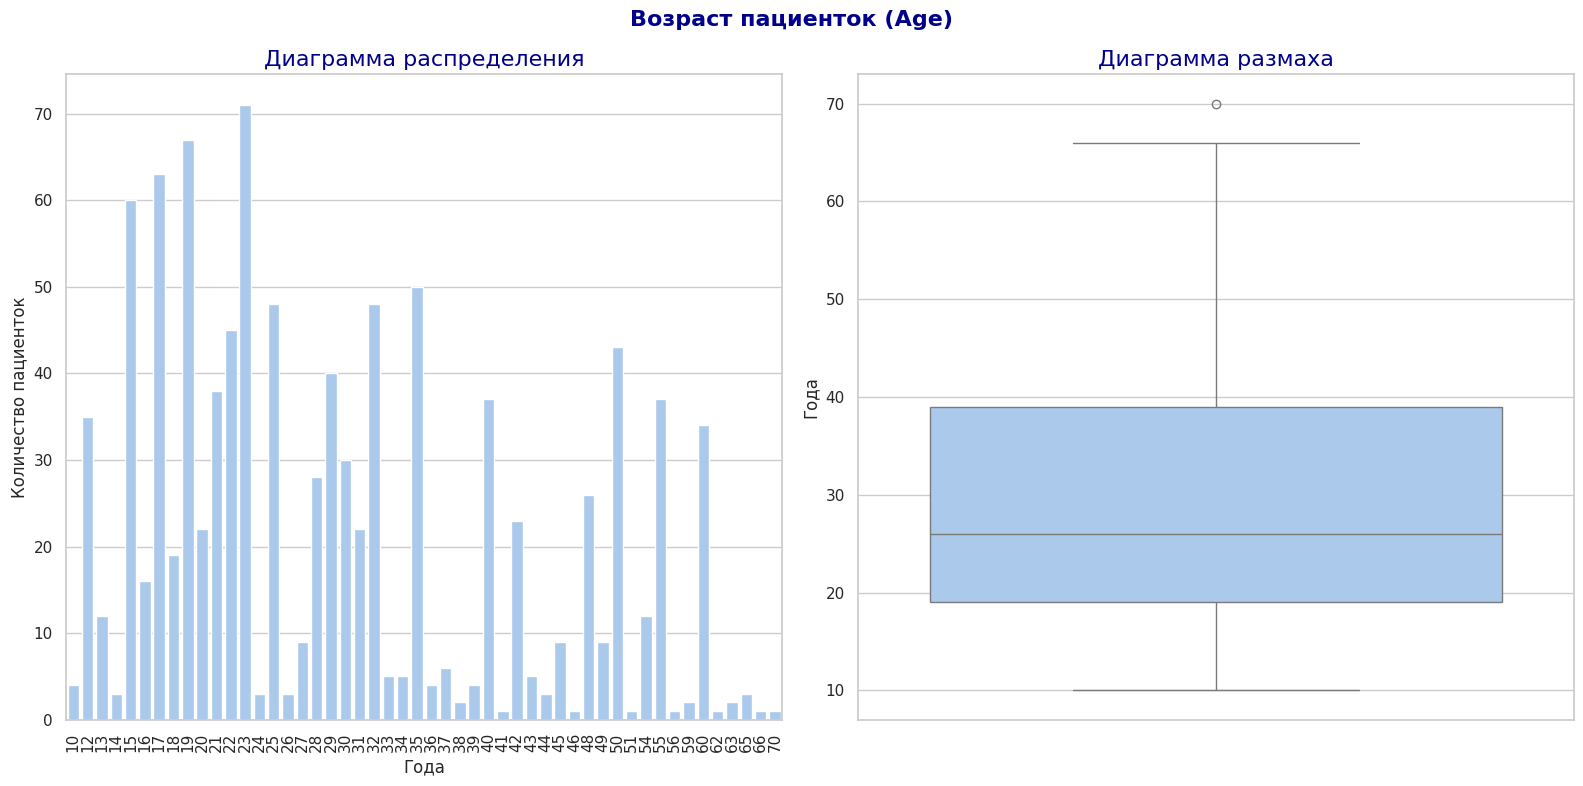

Математическое описание:
count   1,014.00
mean       29.87
std        13.47
min        10.00
25%        19.00
50%        26.00
75%        39.00
max        70.00
Name: Age, dtype: float64
None


In [ ]:
# вызов функции discr_num_discr и ее вывод для возрата
print(discr_num_discr(risk['Age'],
                   'Возраст пациенток (Age)',
                   'Года'))

Возраст пациенток в выборке составляет от 10 до 70 лет, среднее и медиана относительно близки, при этом стандартное отклонение велико. Это указывает на бОльшую долю молодых пациенток, но в выборке хватает представительниц и более старшего возраста (в чем можно было убедиться ранее).

Так и есть: основное "скопление пациенток" находятся в левой части гистограммы. Также можно наблюдать несколько групп (три - ярковыраженные, остальные - менее). Они могут по-разному влиять на целевой признак.

С точки зрения диаграммы размаха пациентка 70 лет является выбросом, что в принципе выглядит логичным (самой старшей после нее 66). Однако с учетом небольшого количества данных (которых станет еще меньше) и необходимостью научить модель работать с разными возрастами я сохраню данную строку.


#### **SystolicBP**

Теперь можно перейти к систолическому давлению (столбец `'SystolicBP'`, выражен в mmHg (мм ртутного столба)).

К данному показателю также можно применить предыдущую функцию для визуализации (тем более, что некоторые значения могут быть не представлены вовсе, о чем можно подозревать исходя из первичного осмотра датасете).

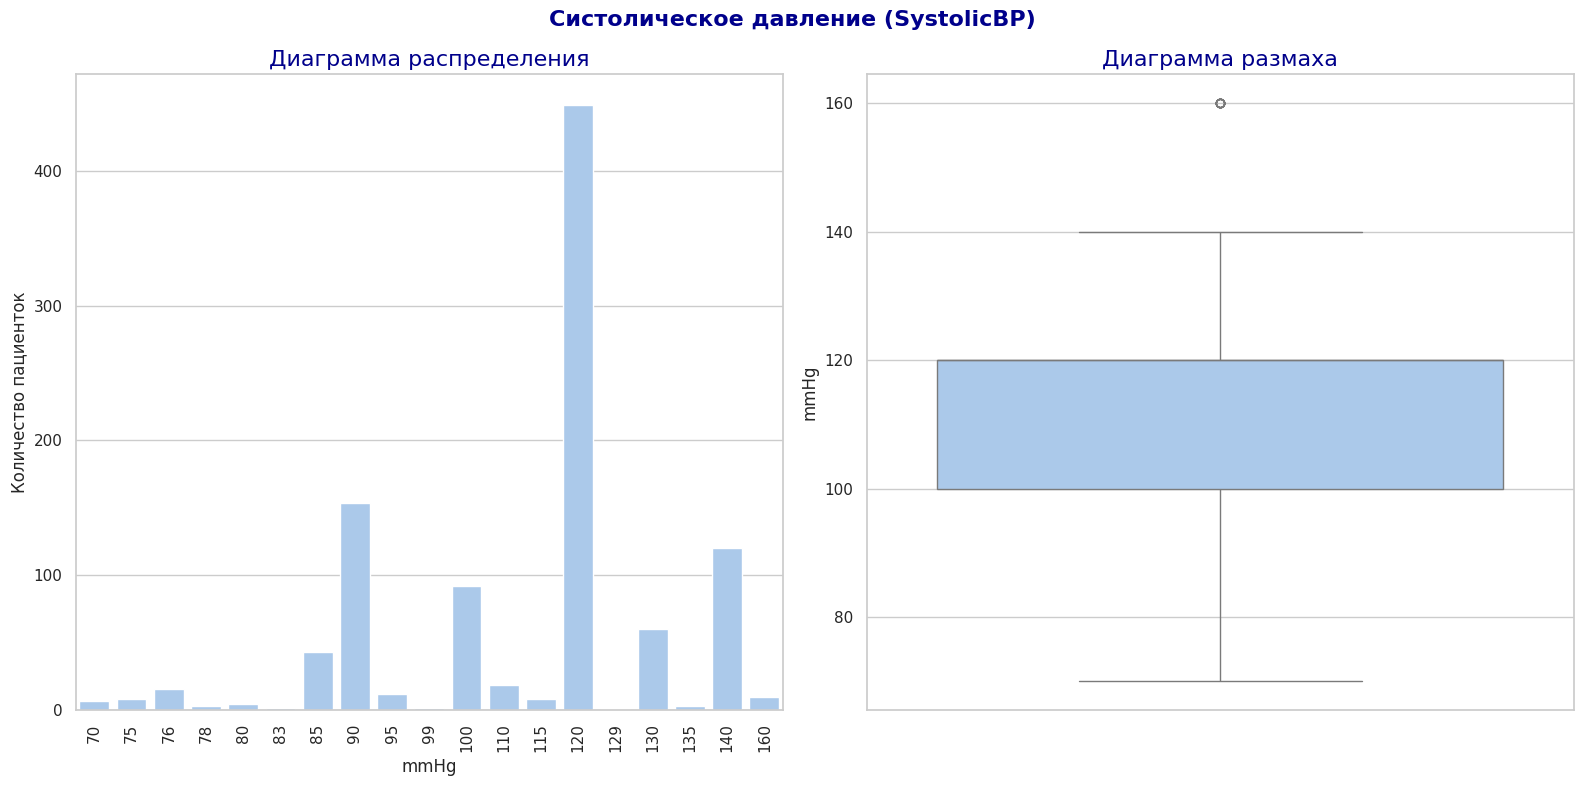

Математическое описание:
count   1,014.00
mean      113.20
std        18.40
min        70.00
25%       100.00
50%       120.00
75%       120.00
max       160.00
Name: SystolicBP, dtype: float64
None


In [ ]:
# вызов функции discr_num_discr и ее вывод для систолического давления
print(discr_num_discr(risk['SystolicBP'],
                   'Систолическое давление (SystolicBP)',
                   'mmHg'))

Наблюдается очень большой разброс между минимумом и максимумом значений, но некоторые значения показателя не представлены вовсе (что выглядит странным). Стандартное отклонение велико, что говорит о неоднородности данных (которое можно наблюдать на диаграмме распределения). При этом медиана совпадает с третьей квартилью, то есть как минимум четверть пациенток имеет систолическое давление в норме (но для беременных она может быть иной).

Здесь также наблюдается несколько групп, чьи границы сложно четко установить ввиду отсутвия некоторых значений ввиду возможн неточного внесения данных. Но также есть и группы риска с необычно высоким или низким "верхним" давлением.

Но с точки зрения ящика с усами выбросом является лишь пацентка с "верхним" давлением в 160.

Посчитаю и выведу некоторых из аномальных паценток дополнительно.

In [ ]:
# считаем пациенток с верхним давлением 90 и ниже (гипотония)
print(color.BLUE + color.BOLD + f"Количество пациенток c систолическим давлением 90 mmHg и ниже: "
+ color.END +f"{len(risk[risk['SystolicBP'] <= 90])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['SystolicBP'] <= 90])/len(risk)*100:.2f} %")

Количество пациенток c систолическим давлением 90 mmHg и ниже: 238
Процент: 23.47 %


Пациенток с верхним давлением 90 mmHg и ниже достаточно много, поэтому сузим диапазон к нижнему краю.

In [ ]:
# считаем пациенток с верхним давлением 80 и ниже
print(color.BLUE + color.BOLD + f"Количество пациенток c систолическим давлением 80 mmHg и ниже: "
+ color.END +f"{len(risk[risk['SystolicBP'] <= 80])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['SystolicBP'] <= 80])/len(risk)*100:.2f} %")

Количество пациенток c систолическим давлением 80 mmHg и ниже: 39
Процент: 3.85 %


In [ ]:
# выводим пациенток с верхним давлением 80 и ниже
print(color.BLUE + color.BOLD + f"=== Пациентки с систолическим давлением 80 mmHg и ниже ==="+ color.END)
risk[risk['SystolicBP'] <= 80]

=== Пациентки с систолическим давлением 80 mmHg и ниже ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
19,10,70,50,6.90,98.00,70,low risk
34,21,75,50,6.10,98.00,70,low risk
48,15,76,49,7.50,98.00,77,low risk
59,15,76,49,6.40,98.00,77,low risk
61,15,80,60,7.00,98.00,80,low risk
146,15,80,60,6.70,98.00,80,low risk
179,21,75,50,6.10,98.00,70,low risk
204,15,76,49,7.50,98.00,77,low risk
226,15,76,49,6.40,98.00,77,low risk
242,15,80,60,7.00,98.00,80,low risk


Пациенток с систолическим давлением с показателями нормы диастолического и ниже (т.е. 80 и менее mmHg) даже более 3%, но при этом практически у всех из них низкий риск. Все из них моложе 21 (большинству 15), что возможно и влияет на показатели давления.

"Разрыв" между систолическим и диастолическим давлением у них небольшой и составляет приблизительно от 14 до 25 единиц.

Также показатели некоторых пациенток полностью дублируются между собой, а значит в датасете для работы с моделю их станет еще меньше.

Теперь посчитаем пациенток с возможной гипертензией (140 и выше mmHg).

In [ ]:
# считаем пациенток с верхним давлением 140 и выше (гипертензия)
print(color.BLUE + color.BOLD + f"Количество пациенток c систолическим давлением 140 mmHg и выше: "
+ color.END +f"{len(risk[risk['SystolicBP'] >=140])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['SystolicBP'] >=140])/len(risk)*100:.2f} %")

Количество пациенток c систолическим давлением 140 mmHg и выше: 130
Процент: 12.82 %


Их достаточно много. Сужу выборку к верхнему краю и посмотрю на них.

In [ ]:
# считаем пациенток с верхним давлением 150 и выше
print(color.BLUE + color.BOLD + f"Количество пациенток c систолическим давлением 150 mmHg и выше: "
+ color.END +f"{len(risk[risk['SystolicBP'] >=150])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['SystolicBP'] >=150])/len(risk)*100:.2f} %")

Количество пациенток c систолическим давлением 150 mmHg и выше: 10
Процент: 0.99 %


In [ ]:
# выводим пациенток с верхним давлением 150 и выше
print(color.BLUE + color.BOLD + f"=== Пациентки с систолическим давлением 150 mmHg и выше ==="+ color.END)
risk[risk['SystolicBP'] >= 150]

=== Пациентки с систолическим давлением 150 mmHg и выше ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
123,40,160,100,19.00,98.00,77,high risk
130,40,160,100,19.00,98.00,77,high risk
166,40,160,100,19.00,98.00,77,high risk
262,40,160,100,19.00,98.00,77,high risk
362,40,160,100,19.00,98.00,77,high risk
538,40,160,100,19.00,98.00,77,high risk
583,40,160,100,19.00,98.00,77,high risk
689,40,160,100,19.00,98.00,77,high risk
961,40,160,100,19.00,98.00,77,high risk
994,40,160,100,19.00,98.00,77,high risk


Таких пациенток не так много и риск у них ожидаемо высок. Однако при этом сами пациентки являются дубликатами между собой (с тем самым показателем-выбросом в 160), а значит в итоговой выбоке останется только одна строка. И ее нельзя исключать полностью как аномалию ввиду ее высокой важности и редкости случая.



#### **DiastolicBP**

Теперь взгляну на диастолическое давление (столбец `'DiastolicBP'`, выражен в mmHg (мм ртутного столба)).

К данному показателю также можно применить предыдущую функцию для визуализации.

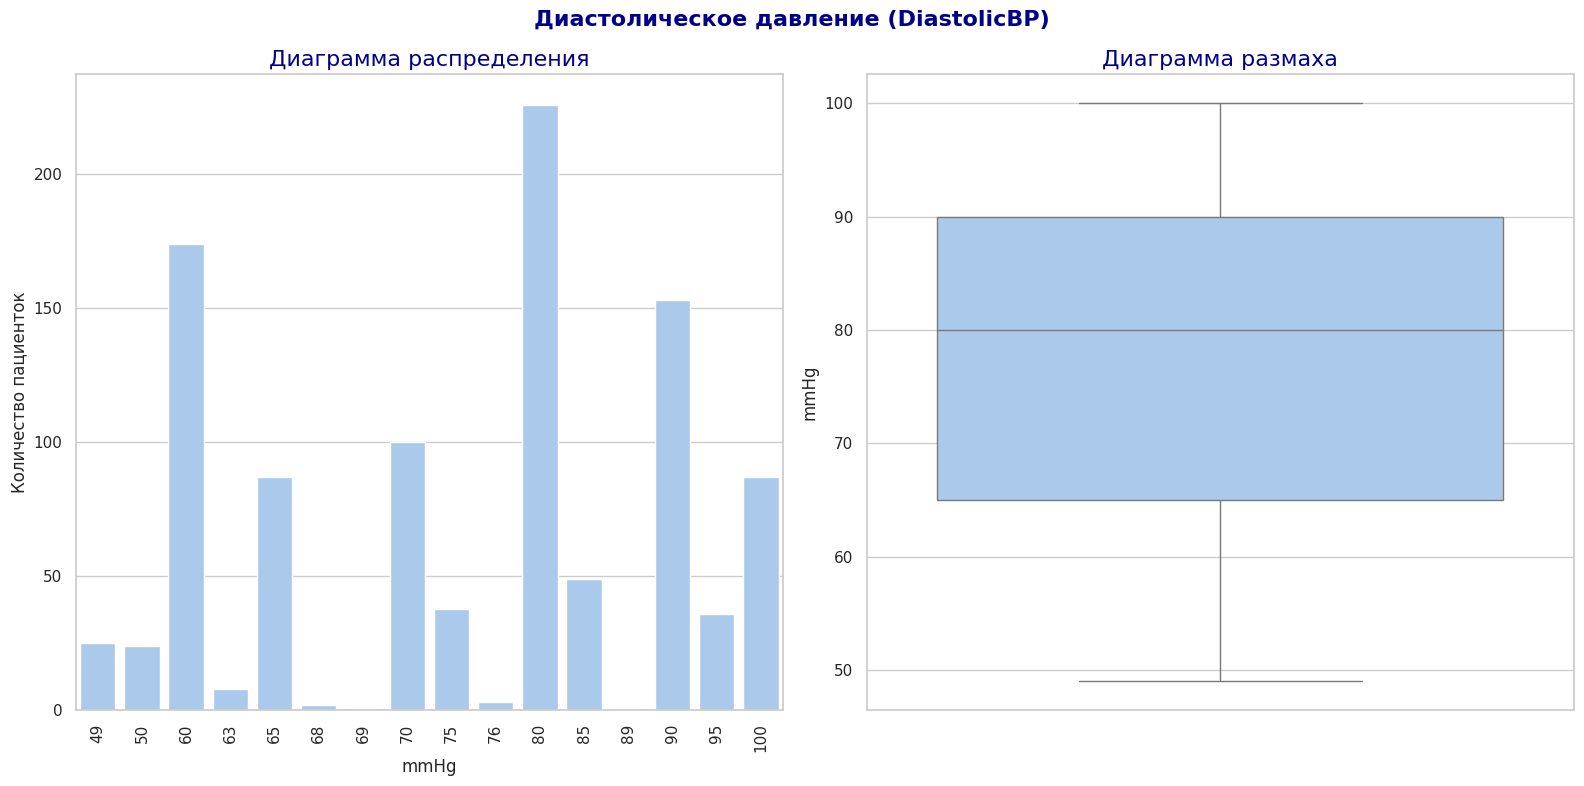

Математическое описание:
count   1,014.00
mean       76.46
std        13.89
min        49.00
25%        65.00
50%        80.00
75%        90.00
max       100.00
Name: DiastolicBP, dtype: float64
None


In [ ]:
# вызов функции discr_num_discr и ее вывод для диастолического давления
print(discr_num_discr(risk['DiastolicBP'],
                   'Диастолическое давление (DiastolicBP)',
                   'mmHg'))

Здесь диапазон значений ужЕ Уже, однако в нем также отсутствуют многие возможные значения. Стандартное отклонение велико, что говорит о неоднородности данных (которое можно наблюдать на диаграмме распределения). С точки зрения диаграммы размаха выбросов нет.

Также можно увидет возможные группы, но из-за особенностей данных правильно сгруппировать их проблематично. Но можно чуть детальнее рассмотреть некоторые из "вне (общей) нормы".

In [ ]:
# считаем пациенток с нижним давлением 60 и ниже (гипотония)
print(color.BLUE + color.BOLD + f"Количество пациенток c диастолическим давлением 60 mmHg и ниже: "
+ color.END +f"{len(risk[risk['DiastolicBP'] <= 60])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['DiastolicBP'] <= 60])/len(risk)*100:.2f} %")

Количество пациенток c диастолическим давлением 60 mmHg и ниже: 223
Процент: 21.99 %


Их достаточно много. Сужу выборку к нижнему краю и посмотрю на них.

In [ ]:
# считаем пациенток с нижним давлением 50 и ниже (гипотония)
print(color.BLUE + color.BOLD + f"Количество пациенток c диастолическим давлением 50 mmHg и ниже: "
+ color.END +f"{len(risk[risk['DiastolicBP'] <= 50])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['DiastolicBP'] <= 50])/len(risk)*100:.2f} %")

Количество пациенток c диастолическим давлением 50 mmHg и ниже: 49
Процент: 4.83 %


In [ ]:
# выводим пациенток с нижним давлением 50 и ниже
print(color.BLUE + color.BOLD + f"=== Пациентки с диастолическим давлением 50 mmHg и ниже ==="+ color.END)
risk[risk['DiastolicBP'] <= 50]

=== Пациентки с диастолическим давлением 50 mmHg и ниже ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
19,10,70,50,6.90,98.00,70,low risk
34,21,75,50,6.10,98.00,70,low risk
48,15,76,49,7.50,98.00,77,low risk
59,15,76,49,6.40,98.00,77,low risk
179,21,75,50,6.10,98.00,70,low risk
204,15,76,49,7.50,98.00,77,low risk
226,15,76,49,6.40,98.00,77,low risk
275,21,75,50,7.70,98.00,60,low risk
300,15,75,49,7.70,98.00,77,low risk
370,21,75,50,7.80,98.00,60,low risk


Также в основном (часто - очень) молодые пациентки с низким риском. "Разрыв" между систолическим и диастолическим давлением у них составляет приблизительно от 20 до 51 единицы. Заметного дублирования данных в строках не наблюдается.

Теперь перейду к высоким показателям.

In [ ]:
# считаем пациенток с нижним давлением 90 и выше (гипертензия)
print(color.BLUE + color.BOLD + f"Количество пациенток c диастолическим давлением 90 mmHg и выше: "
+ color.END +f"{len(risk[risk['DiastolicBP'] >= 90])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['DiastolicBP'] >= 90])/len(risk)*100:.2f} %")

Количество пациенток c диастолическим давлением 90 mmHg и выше: 276
Процент: 27.22 %


Их достаточно много. Сужу выборку к верхнему краю и посмотрю на них.

In [ ]:
# считаем пациенток с нижним давлением 100 и выше (гипертензия)
print(color.BLUE + color.BOLD + f"Количество пациенток c диастолическим давлением 100 mmHg и выше: "
+ color.END +f"{len(risk[risk['DiastolicBP'] >= 100])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['DiastolicBP'] >= 100])/len(risk)*100:.2f} %")

Количество пациенток c диастолическим давлением 100 mmHg и выше: 87
Процент: 8.58 %


In [ ]:
# выводим пациенток с нижним давлением 100 и выше
print(color.BLUE + color.BOLD + f"=== Пациентки с диастолическим давлением 100 mmHg и выше ==="+ color.END)
risk[risk['DiastolicBP'] >= 100]

=== Пациентки с диастолическим давлением 100 mmHg и выше ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
17,25,140,100,7.01,98.00,80,high risk
20,40,140,100,18.00,98.00,90,high risk
103,25,140,100,6.80,98.00,80,high risk
107,25,140,100,6.80,98.00,80,high risk
108,42,140,100,18.00,98.00,90,high risk
109,32,140,100,7.90,98.00,78,high risk
113,30,140,100,15.00,98.00,70,high risk
115,25,140,100,7.90,98.00,80,high risk
117,55,140,100,18.00,98.00,90,high risk
118,32,140,100,7.90,98.00,78,high risk


Таких пациенток достаточно много, большинство из них имеет высокий риск (и лишь немногие - средний). "Разрыв" между систолическим и диастолическим давлением у них составляет приблизительно от 30 до 60 единиц. Заметного дублирования данных в строках не наблюдается.

#### **BS**

Теперь взгляну на уровень глюкозы в крови (столбец `'BS'`, выражен в mmol/L (ммоль/л)).

Тут уже значения являются неприрывными, а значит нужна более подходящая функция. Диапазон значений у нас небольшой, поэтому корзин также много не требуется.

In [ ]:
# создание функции для будущего описания числовых недискретных признаков
def discr_num(col_data, title, x_label, bins=25):
    # создание графиков: гистограмма и диаграмма размаха
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # гистограмма
    # сортируем уникальные значения по возрастанию для правильного порядка
    sns.histplot(data=col_data, bins=bins, kde=True, ax=axs[0])
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel('Количество пациенток')
    axs[0].set_title('Диаграмма распределения', color='darkblue')
    axs[0].tick_params(axis='x', rotation=90)  # поворот подписей для удобства

    # диаграмма размаха
    sns.boxplot(data=col_data, ax=axs[1])
    axs[1].set_ylabel(x_label)
    axs[1].set_title('Диаграмма размаха', color='darkblue')

    # заголовок графиков
    fig.suptitle(title, color='darkblue', fontsize=16, fontweight='bold')

    # показать графики и вернуть описательные статистики
    plt.tight_layout()
    plt.show()
    return print(color.BLUE + color.BOLD +f"Математическое описание:\n"+ color.END + f"{col_data.describe()}")

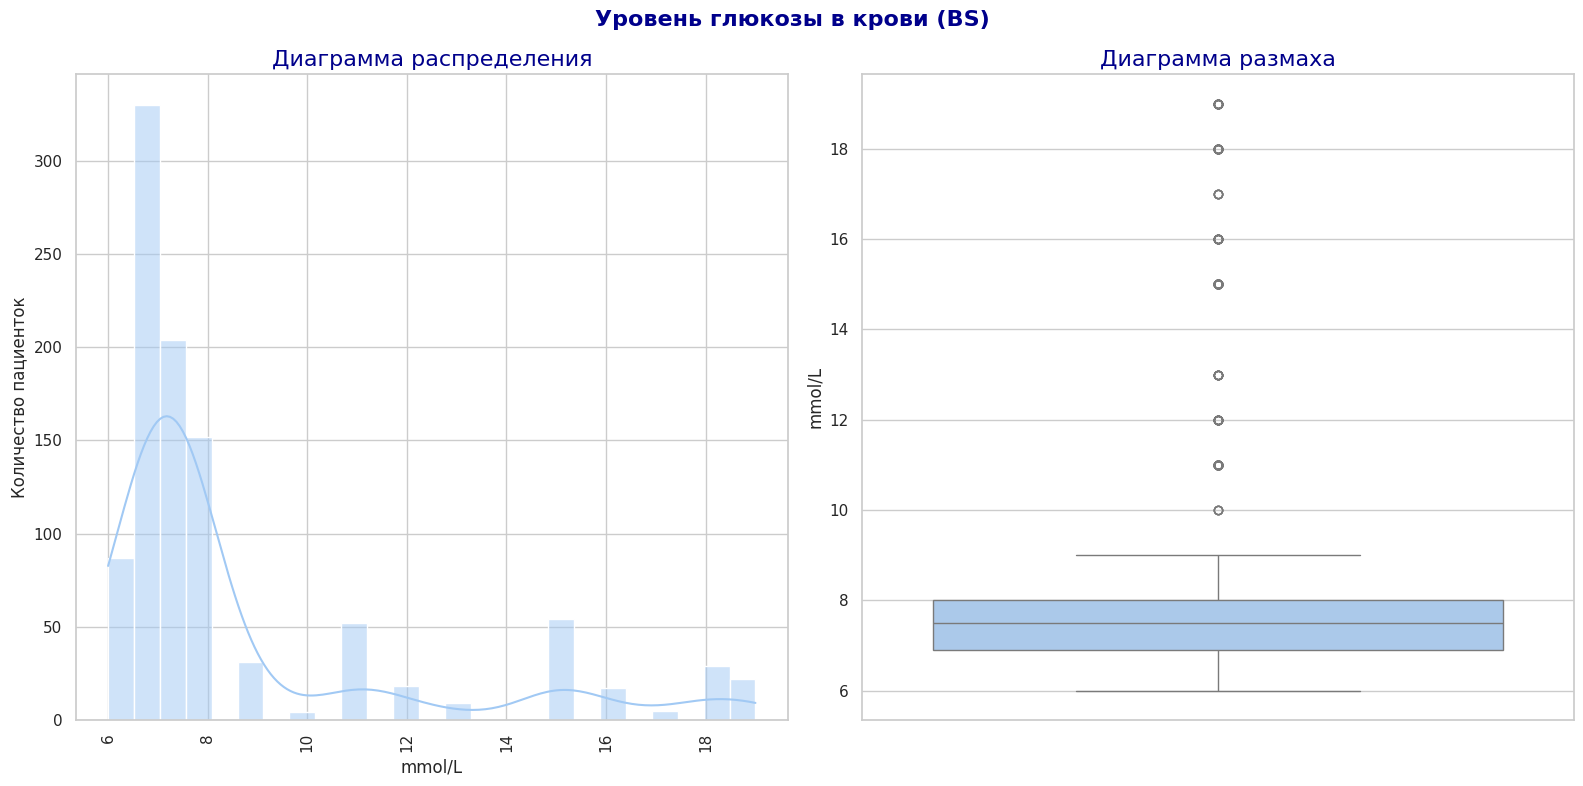

Математическое описание:
count   1,014.00
mean        8.73
std         3.29
min         6.00
25%         6.90
50%         7.50
75%         8.00
max        19.00
Name: BS, dtype: float64
None


In [ ]:
# вызов функции discr_num_discr и ее вывод для уровня глюкозы в крови
print(discr_num(risk['BS'],
                   'Уровень глюкозы в крови (BS)',
                   'mmol/L'))

Первая квартиль достаточно близка к минимуму, что вместе с гистограммой показывает смещение влево (ближе к "обычной норме", которая через час после еды составляет 7.8 ммоль/л, но для беременных может быть иной). Также на гистограмме можно наблюдать дополнительные пики, которые с точки зрения ящика с усами являются выбросами.

Выведу их.

In [ ]:
# считаем пациенток с уровнем глюкозы в крови выше 9
print(color.BLUE + color.BOLD + f"Количество пациенток с уровнем глюкозы в крови выше 9 mmol/L: "
+ color.END +f"{len(risk[risk['BS'] > 9])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['BS'] > 9])/len(risk)*100:.2f} %")

Количество пациенток с уровнем глюкозы в крови выше 9 mmol/L: 210
Процент: 20.71 %


Их достаточно много, то есть их нельзя исключать из исследования.

Сужу выборку к верхнему краю и посмотрю на них.

In [ ]:
# считаем пациенток с уровнем глюкозы в крови выше 15
print(color.BLUE + color.BOLD + f"Количество пациенток с уровнем глюкозы в крови выше 15 mmol/L: "
+ color.END +f"{len(risk[risk['BS'] > 15])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['BS'] > 15])/len(risk)*100:.2f} %")

Количество пациенток с уровнем глюкозы в крови выше 15 mmol/L: 73
Процент: 7.20 %


In [ ]:
# выводим пациенток с уровнем глюкозы в крови выше 15
print(color.BLUE + color.BOLD + f"=== Пациентки с  уровнем глюкозы в крови выше 15 mmol/L ==="+ color.END)
risk[risk['BS'] > 15]

=== Пациентки с  уровнем глюкозы в крови выше 15 mmol/L ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
9,42,130,80,18.00,98.00,70,high risk
20,40,140,100,18.00,98.00,90,high risk
74,44,120,90,16.00,98.00,80,mid risk
108,42,140,100,18.00,98.00,90,high risk
110,50,140,95,17.00,98.00,60,high risk
117,55,140,100,18.00,98.00,90,high risk
123,40,160,100,19.00,98.00,77,high risk
124,32,140,90,18.00,98.00,88,high risk
127,55,140,95,19.00,98.00,77,high risk
130,40,160,100,19.00,98.00,77,high risk


Ожидаемо, что у большинства пациенток с уровнем глюкозы в крови выше 15 высокий рик (у части - средний). Также для многих характерны высокие показатели давления.

Также встречнается дублирование строк, но немного.

#### **BodyTemp**

Теперь можно перейти к систолическому давлению (столбец `'SystolicBP'`, выражен в mmHg (мм ртутного столба)).

Хоть данный столбец и имеет тип float, но с большой долей вероятности к данному показателю также можно применить первую из функции для "математической визуализации". Для подтверждения или опровержения этого выведем уникальные значения столбца.

In [ ]:
# выводим уникальные значения столбца
# с сортировкой для удобства восприятия
sorted(risk['BodyTemp'].unique())

[np.float64(98.0),
 np.float64(98.4),
 np.float64(98.6),
 np.float64(99.0),
 np.float64(100.0),
 np.float64(101.0),
 np.float64(102.0),
 np.float64(103.0)]

Диапазон невелик, и количество возможных значений у нас также невелико (и промежутки между ними различны).

После размышлений, я все же решила описать его как недискретный, с использованием той же функции, что применяла для уровня глюкозы в крови.

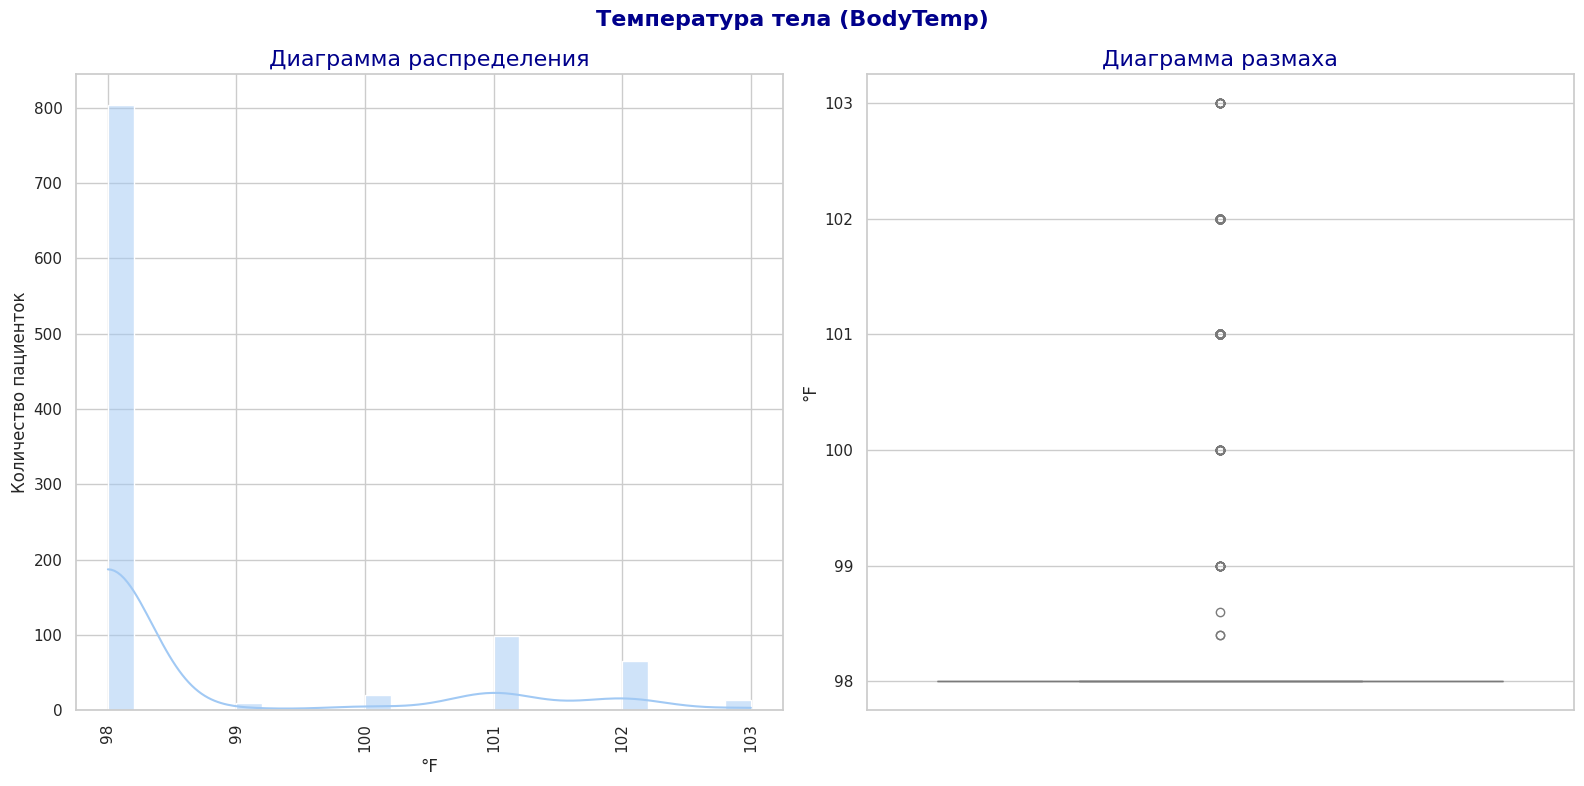

Математическое описание:
count   1,014.00
mean       98.67
std         1.37
min        98.00
25%        98.00
50%        98.00
75%        98.00
max       103.00
Name: BodyTemp, dtype: float64
None


In [ ]:
# вызов функции discr_num_discr и ее вывод для температуры тела
print(discr_num(risk['BodyTemp'],
                   'Температура тела (BodyTemp)',
                   '°F'))

Большая часть пациенток находится в пределах "обычной нормы" в 96.8-99.0°F (для беременных она может быть иная). Можно сказать даже что почти все пациентки имеют температуру в 98°F, поэтому иные значения являются аномалиями с точки зрения диаграммы размаха.

Посчитаю их.

In [ ]:
# считаем пациенток с температурой выше 98
print(color.BLUE + color.BOLD + f"Количество пациенток с температурой тела выше 98°F: "
+ color.END +f"{len(risk[risk['BodyTemp'] > 98])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['BodyTemp'] > 98])/len(risk)*100:.2f} %")

Количество пациенток с температурой тела выше 98°F: 210
Процент: 20.71 %


Их достаточно много, то есть их нельзя исключать из исследования.

Сужу выборку к верхнему краю и посмотрю на них.

In [ ]:
# считаем пациенток с температурой 100 и выше
print(color.BLUE + color.BOLD + f"Количество пациенток с температурой тела 100°F и выше: "
+ color.END +f"{len(risk[risk['BodyTemp'] >= 100])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['BodyTemp'] >= 100])/len(risk)*100:.2f} %")

Количество пациенток с температурой тела 100°F и выше: 197
Процент: 19.43 %


Пациенток с температурой тела выше 100 °F также достаточно много. Поэтому посмотрим лишь самую крайность в показателях.

In [ ]:
# считаем пациенток с температурой 103
print(color.BLUE + color.BOLD + f"Количество пациенток с температурой тела 103°F: "
+ color.END +f"{len(risk[risk['BodyTemp'] == 103])}")

print(color.BLUE + color.BOLD +f"Процент: "+ color.END +
      f"{len(risk[risk['BodyTemp'] == 103])/len(risk)*100:.2f} %")

Количество пациенток с температурой тела 103°F: 13
Процент: 1.28 %


In [ ]:
# выводим пациенток с температурой 103
print(color.BLUE + color.BOLD + f"=== Пациентки с температурой 103°F ==="+ color.END)
risk[risk['BodyTemp'] == 103]

=== Пациентки с температурой 103°F ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
191,17,90,65,6.10,103.00,67,high risk
287,17,90,65,7.70,103.00,67,high risk
337,45,120,80,6.90,103.00,70,low risk
339,65,120,90,6.90,103.00,76,low risk
342,22,120,80,6.90,103.00,76,low risk
382,17,90,65,7.80,103.00,67,high risk
419,17,140,100,6.80,103.00,80,high risk
563,17,90,65,7.50,103.00,67,low risk
612,17,90,65,7.50,103.00,67,mid risk
834,17,90,65,7.50,103.00,67,mid risk


Данных пациенток немного, они имеют разные уровни риска.

При этом можно наблюдать, что при одинаковых между собой значениях некоторые пациентки (563 и 612, 970) при этом иногда получали разные уровни риска. Что вновь говорит о недостаточности используемых показателей.

В имеющихся данных есть столбец с температурой, не заявленный в описании. Возможно, были еще признаки, которые не попали в этот датасет, которые также оказывали влияние на целевой признак.

#### **HeartRate**

Теперь можно перейти к частоте сердечного ритма (столбец 'HeartRate', выражен в ударах в минуту).

Применю к нему ту же функцию, что и к возрасту.

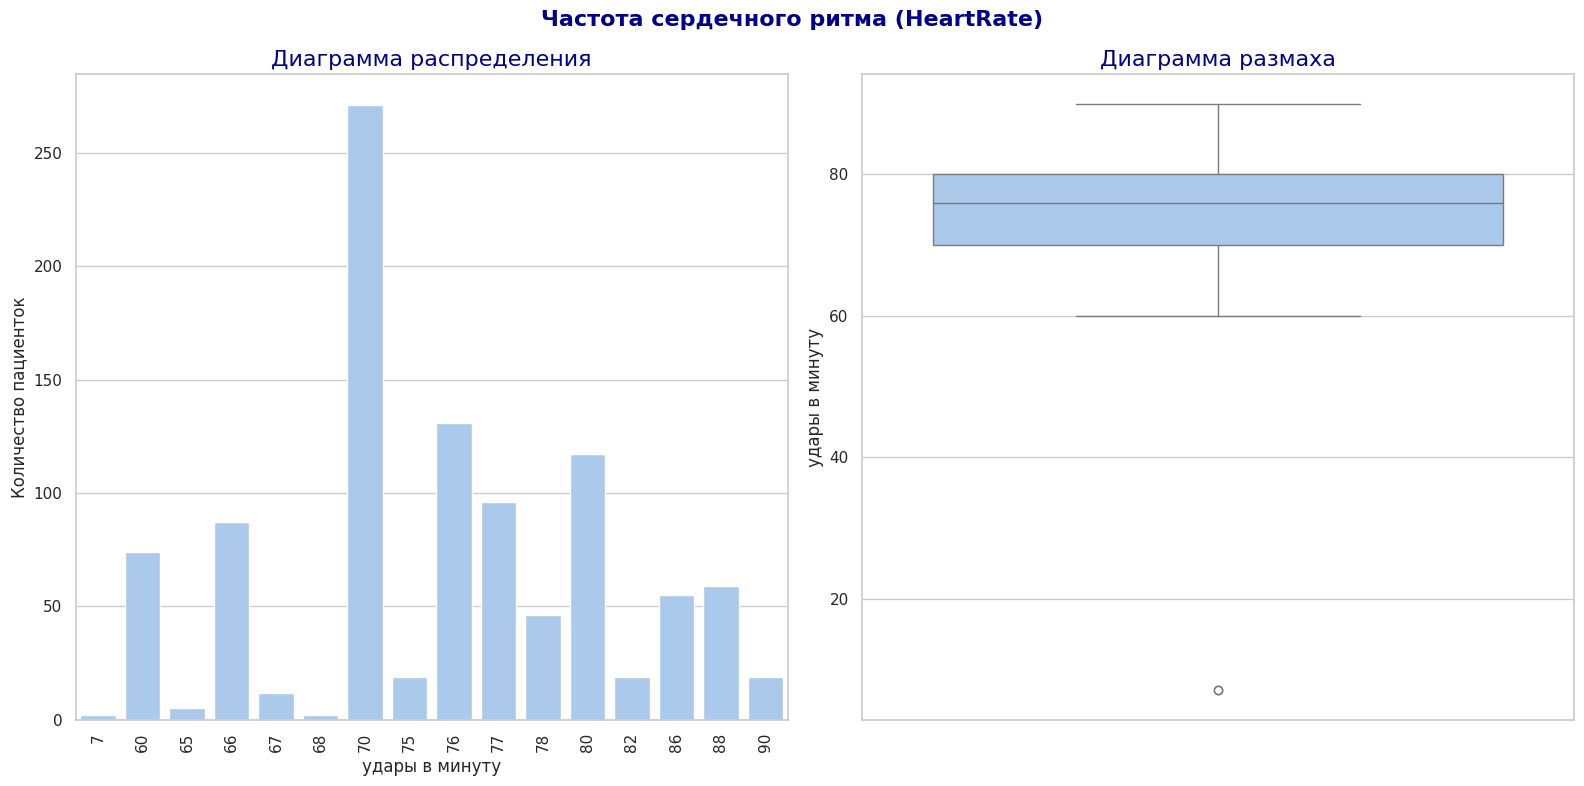

Математическое описание:
count   1,014.00
mean       74.30
std         8.09
min         7.00
25%        70.00
50%        76.00
75%        80.00
max        90.00
Name: HeartRate, dtype: float64
None


In [ ]:
# вызов функции discr_num_discr и ее вывод для сердечного ритма
print(discr_num_discr(risk['HeartRate'],
                   'Частота сердечного ритма (HeartRate)',
                   'удары в минуту'))

Здесь у также представлены не все возможные значения. И видна яркая аномалия в 7 единиц.

Выведу ее.

In [ ]:
# выводим пациенток с 7 ударами в минуту
print(color.BLUE + color.BOLD + f"=== Пациентки с 7 ударами в минуту ==="+ color.END)
risk[risk['HeartRate'] == 7]

=== Пациентки с 7 ударами в минуту ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.90,98.00,7,low risk
908,16,120,75,7.90,98.00,7,low risk


Это пациентки - дубликаты, которые несмотря на столь низкую частоту имеют низкий уровень риска.

"Оторванность" данных строк и их небольшое количество указывает на то, что данное значение - ошибочно (возможно, на самам деле это было 70). А значит в будущем можно будет его удалить.

### **Целевой признак (RiskLevel)**

Теперь посмотрю на баланс классов.

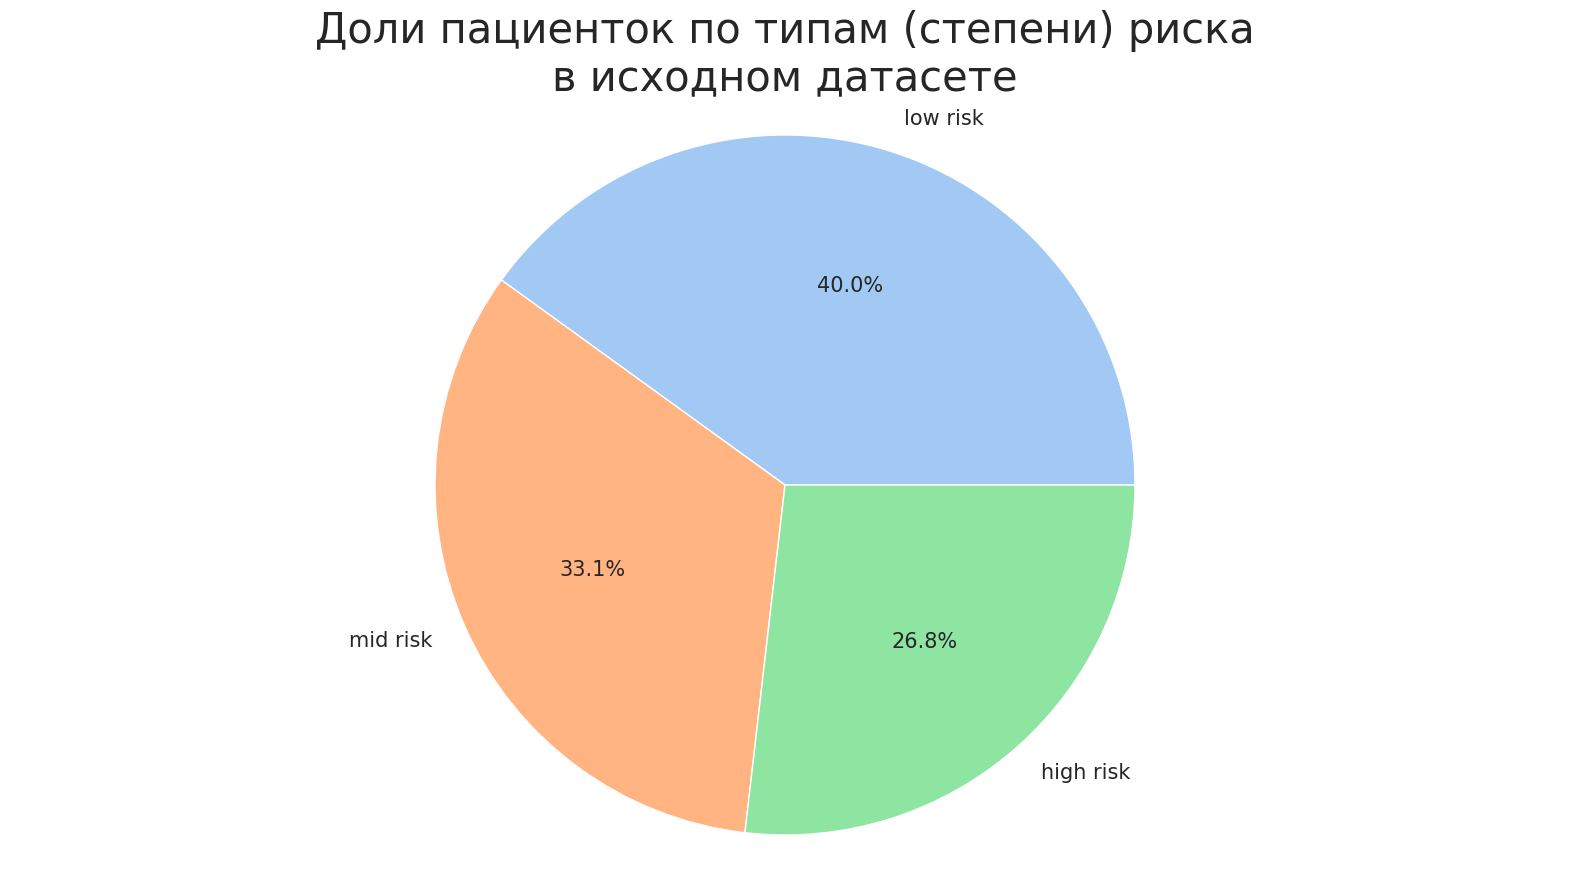

In [ ]:
# визуализируем целевой признак в исходном датасете
risk['RiskLevel'].value_counts().plot(kind = 'pie', grid = True,\
                                     figsize = (20,10), fontsize=15, autopct='%1.1f%%')

plt.title('Доли пациенток по типам (степени) риска\nв исходном датасете', fontsize=30)
plt.axis('equal')
plt.ylabel('', fontsize=13)

plt.show()

Классы не сбалансированы, однако сильного дисбаланса в них нет.

Выведу математические описания с учетом показателей (более подробно связь буду смотреть через матрицу корреляции позже).

In [ ]:
# статистическое описание исходного датасета для низкого риска
print(color.BLUE + color.BOLD + f"=== Статистическое описание исходной выборки для "+ color.END
      + color.GREEN + color.BOLD + f"низкого уровня риска ==="+ color.END)
risk[risk['RiskLevel']=='low risk'].describe()

=== Статистическое описание исходной выборки для низкого уровня риска ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,406.00,406.00,406.00,406.00,406.00,406.00
mean,26.87,105.87,72.53,7.22,98.37,72.77
std,13.12,15.89,13.05,0.65,1.11,8.29
min,10.00,70.00,49.00,6.00,98.00,7.00
25%,17.00,90.00,60.00,6.90,98.00,70.00
50%,22.00,120.00,75.00,7.50,98.00,70.00
75%,32.00,120.00,80.00,7.50,98.00,77.00
max,70.00,129.00,100.00,11.00,103.00,88.00


Медианным пациентом низкого уровня риска является пациентка 22 лет, с давлением 120/75, уровнем глюкозы 7.5, температурой 98°F и сердечным ритмом 70 ударов в мин - то есть показатели совпадают либо близко к "обычной норме".

In [ ]:
# статистическое описание исходного датасета для среднего риска
print(color.BLUE + color.BOLD + f"=== Статистическое описание исходной выборки для "+ color.END
      + color.YELLOW + color.BOLD + f"среднего уровня риска ==="+ color.END)
risk[risk['RiskLevel']=='mid risk'].describe()

=== Статистическое описание исходной выборки для среднего уровня риска ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,336.00,336.00,336.00,336.00,336.00,336.00
mean,28.36,113.15,74.23,7.80,98.83,74.18
std,12.55,14.98,11.49,2.29,1.43,6.77
min,10.00,70.00,50.00,6.00,98.00,60.00
25%,19.00,100.00,65.00,6.80,98.00,70.00
50%,25.00,120.00,75.00,7.00,98.00,76.00
75%,32.00,120.00,80.00,7.80,100.00,78.00
max,60.00,140.00,100.00,18.00,103.00,88.00


Медианным пациентом среднего уровня риска является пациентка 25 лет (старше низкого), с давлением 120/75 mmHg (совпадает), уровнем глюкозы 7.0 mmol/L (ниже), температурой тела 98°F (совпадает) и сердечным ритмом 76 (выше) ударов в мин - то есть показатели также совпадают либо близки (но отклонения чуть больше) к "обычной норме".

In [ ]:
# статистическое описание исходного датасета для высокого риска
print(color.BLUE + color.BOLD + f"=== Статистическое описание исходной выборки для "+ color.END
      + color.RED + color.BOLD + f"высокого уровня риска ==="+ color.END)
risk[risk['RiskLevel']=='high risk'].describe()

=== Статистическое описание исходной выборки для высокого уровня риска ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,272.00,272.00,272.00,272.00,272.00,272.00
mean,36.22,124.19,85.07,12.12,98.90,76.74
std,13.03,20.23,14.11,4.17,1.56,8.70
min,12.00,83.00,60.00,6.10,98.00,60.00
25%,25.00,120.00,75.00,7.90,98.00,70.00
50%,35.00,130.00,90.00,11.00,98.00,77.00
75%,48.00,140.00,100.00,15.00,100.00,86.00
max,65.00,160.00,100.00,19.00,103.00,90.00


Медианным пациентом высокого уровня риска является пациентка 35 лет (еще старше), с давлением 130/90 (становится выше), уровнем глюкозы 11 (также выше), температурой 98°F и сердечным ритмом 77 ударов в мин - то есть показатели в основном выше "обычной нормы".

### **Матрица корреляции**

Также можно взглянуть матрицу корреляции для всей выборки.

In [ ]:
# неприрывные значения
interval_cols = ['BS', 'BodyTemp']

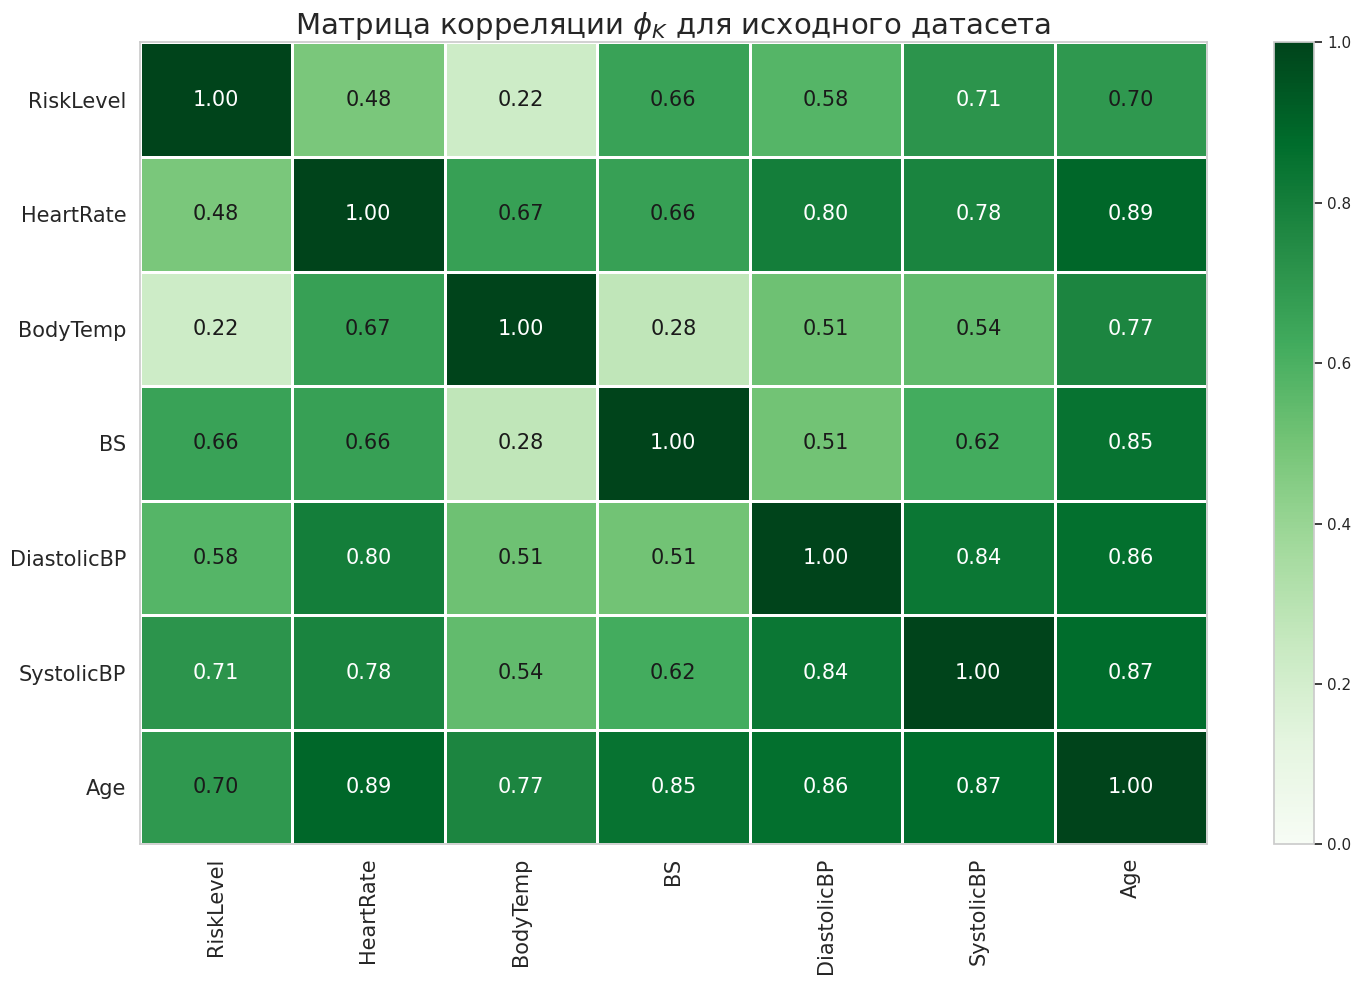

In [ ]:
# считаем корреляции для всего датасета
phik_overview_full = risk.phik_matrix(interval_cols=interval_cols)

# матрица корреляции
plot_correlation_matrix(
    phik_overview_full.values,
    x_labels=phik_overview_full.columns,
    y_labels=phik_overview_full.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции $\phi_K$ для исходного датасета',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Ожидаемо слабую кореляцию с целевым признаком показала температура тела. Возможно, имено поэтому ее столбец не включили в описание данных.

Самая сильная связь с целевым признаком - у систолического давления и возраста.

У возраста и частоты сердечноного ритма самые высокие степени корреляции со всеми остальными признаками.

Мультиколлинеарность отсутствует.

Исходная выборка исследована, теперь можно идти дальше.

### **Выводы**

Я провела исследовательский анализ для исходной выборки. В результате чего было выявлено:

- Нормальными значениями со статистической точки зрения в рамках исходной выборки являются:
    - Для возраста (`'Age'`) - 19-39 лет;
    - Для систолического давления (`'SystolicBP'`) - 100-120 mmHg;
    - Для диастолического давления (`'DiastolicBP'`) - 65-90 mmHg;
    - Для уровня глюкозы в крови (`'BS'`) - 6.9-8.0 mmol/L;
    - Для температуры тела(`'BodyTemp'`) - 98°F;
    - Для сердечного ритма (`'HeartRate'`) - 70-80 ударов в мин.
- Классы целевого признака не сбалансированы, однако сильного дисбаланса в них нет.
- Медианным пациентом для следующих уровней риска являются:
    - низкого: пациентка 22 лет, с давлением 120/75, уровнем глюкозы 7.5, температурой 98°F и сердечным ритмом 70 ударов в мин - то есть показатели совпадают либо близко к "обычной норме";
    - среднего: пациентка 25 лет, с давлением 120/75 mmHg, уровнем глюкозы 7.0 mmol/L, температурой тела 98°F и сердечным ритмом 76 ударов в мин - то есть показатели также совпадают либо близки (но отклонения чуть больше) к "обычной норме".
    - высокого: пациентка 35 лет (еще старше), с давлением 130/90 (становится выше), уровнем глюкозы 11 (также выше), температурой 98°F и сердечным ритмом 77 ударов в мин - то есть показатели в основном выше "обычной нормы".

- Для некоторых признаков вероятно могли использоваться не точные, а приближеные значения.    
- Часто значения признаков объединяются в несколько групп, которые не всегда можно точно разделить.
- Сборщики данных постарались уделить дополнительное внимания "особым группам" (со слишком высокими или низкими значениями признака относительно нормы) и увеличить их представленность в выборке для лучшего обучения модели.
- Имеющихся показателей (их очень мало) и значений части из них (вероятность использования приближений) недостаточно не только для различения пациенток между собой, но и для построения корректной модели: разные пациентки могут не не только имеют одинаковые значения признаков (и доля таковых велика, как было видно ранее), но и при этом иметь разный уровень риска (целевого признака).
- Матрица корреляции исходного датассета показала:
    - Самая слабая корреляция с целевым признаком у температуры тела.
    - Самая сильная связь с целевым признаком - у систолического давления и возраста.
    - У возраста и частоты сердечноного ритма самые высокие степени корреляции со всеми остальными признаками.
    - Мультиколлинеарность отсутствует.

- После очистки датасета от ошибочных значений (обнаруженных в поаказатях сердечного ритма) и дубликатов (выявленных ранее) возможны смещения медиан и средних, а также изменение баланса классов.

## **Анализ очищенного датасета**

Теперь очищу датасет от выброса частоты ритма (ошибочные данные) и от полных дубликатов (во избежание утечки данных).

Неполные, что отличаются лишь целевым признаком, удалять не буду, чтоб не искажать данные (так как можно предположить, что данные реальны, но в датасете нет признаков, которые своим влиянием привели к такому различию в результате).

In [ ]:
# создаем копию датасета, очищенного от дубликатов
risk_drop = risk.copy()
risk_drop = risk_drop.drop_duplicates()
risk_drop = risk_drop[risk_drop['HeartRate'] != 7]

In [ ]:
# вызов функции discr_num и ее вывод
first_discr(risk_drop,'risk_drop', 15)


 === Первые 15 строк в risk_drop: ===



,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.00,86,high risk
1,35,140,90,13.00,98.00,70,high risk
2,29,90,70,8.00,100.00,80,high risk
3,30,140,85,7.00,98.00,70,high risk
4,35,120,60,6.10,98.00,76,low risk
5,23,140,80,7.01,98.00,70,high risk
6,23,130,70,7.01,98.00,78,mid risk
7,35,85,60,11.00,102.00,86,high risk
8,32,120,90,6.90,98.00,70,mid risk
9,42,130,80,18.00,98.00,70,high risk



 === Общая информация о данных в risk_drop: ===

<class 'pandas.core.frame.DataFrame'>
Index: 451 entries, 0 to 705
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          451 non-null    int64  
 1   SystolicBP   451 non-null    int64  
 2   DiastolicBP  451 non-null    int64  
 3   BS           451 non-null    float64
 4   BodyTemp     451 non-null    float64
 5   HeartRate    451 non-null    int64  
 6   RiskLevel    451 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 28.2+ KB


None


 === Размер датасета risk_drop:===
    (451, 7)


 === Явные дубликаты в risk_drop:===
Количество: 0
Процент: 0.00 %


Количество строк в очищенном от дубликатов датасете заметно уменьшилось, а сами дубликаты отсутствуют.

Выведу статистическое описание для очищенного датасета. А перед ним - описание неочищенного (для удобства сравнения).

In [ ]:
# статистическое описание исходного датасета
print(color.BLUE + color.BOLD + f"=== Статистическое описание исходной выборки ==="+ color.END)
risk.describe()

=== Статистическое описание исходной выборки ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,"1,014.00","1,014.00","1,014.00","1,014.00","1,014.00","1,014.00"
mean,29.87,113.20,76.46,8.73,98.67,74.30
std,13.47,18.40,13.89,3.29,1.37,8.09
min,10.00,70.00,49.00,6.00,98.00,7.00
25%,19.00,100.00,65.00,6.90,98.00,70.00
50%,26.00,120.00,80.00,7.50,98.00,76.00
75%,39.00,120.00,90.00,8.00,98.00,80.00
max,70.00,160.00,100.00,19.00,103.00,90.00


In [ ]:
# статистическое описание очищенного датасета
print(color.BLUE + color.BOLD + f"=== Статистическое описание очищенной выборки ==="+ color.END)
risk_drop.describe()

=== Статистическое описание очищенной выборки ===


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,451.00,451.00,451.00,451.00,451.00,451.00
mean,29.22,110.53,75.42,8.35,98.69,74.10
std,13.77,17.89,13.77,2.83,1.41,7.53
min,10.00,70.00,49.00,6.00,98.00,60.00
25%,19.00,90.00,65.00,6.90,98.00,70.00
50%,25.00,120.00,80.00,7.50,98.00,76.00
75%,35.00,120.00,87.00,7.90,98.00,80.00
max,70.00,160.00,100.00,19.00,103.00,90.00


Статистически нормальными диапазонами для
 для очищенной выборки является:
- Для возраста (`'Age'`) - 19-35 лет (верхний диапазон снизился);
    - Для систолического давления (`'SystolicBP'`) - 90-120 mmHg (нижний диапазон снизился);
    - Для диастолического давления (`'DiastolicBP'`) - 65-87 mmHg (верхний диапазон чуть снизился);
    - Для уровня глюкозы в крови (`'BS'`) - 6.9-7.9 mmol/L (верхний диапазон чуть снизился);
    - Для температуры тела(`'BodyTemp'`) - 98°F (тот же);
    - Для сердечного ритма (`'HeartRate'`) - 70-80 ударов в мин (тот же).

То есть диапазоны значений либо не изменились, либо чуть сузились за счет уменьшения верхнего предела нормы (исключение - систолическое давление, у которого диапазон напротив чуть расширился). Медианы не изменились (лишь у возраста увеличилась на год). То есть при сравнении статистических показателей (этих и других) можно утверждать, что очищенный датасет в некотором роде близок к исходному.

Теперь изучу рапределение по классам.

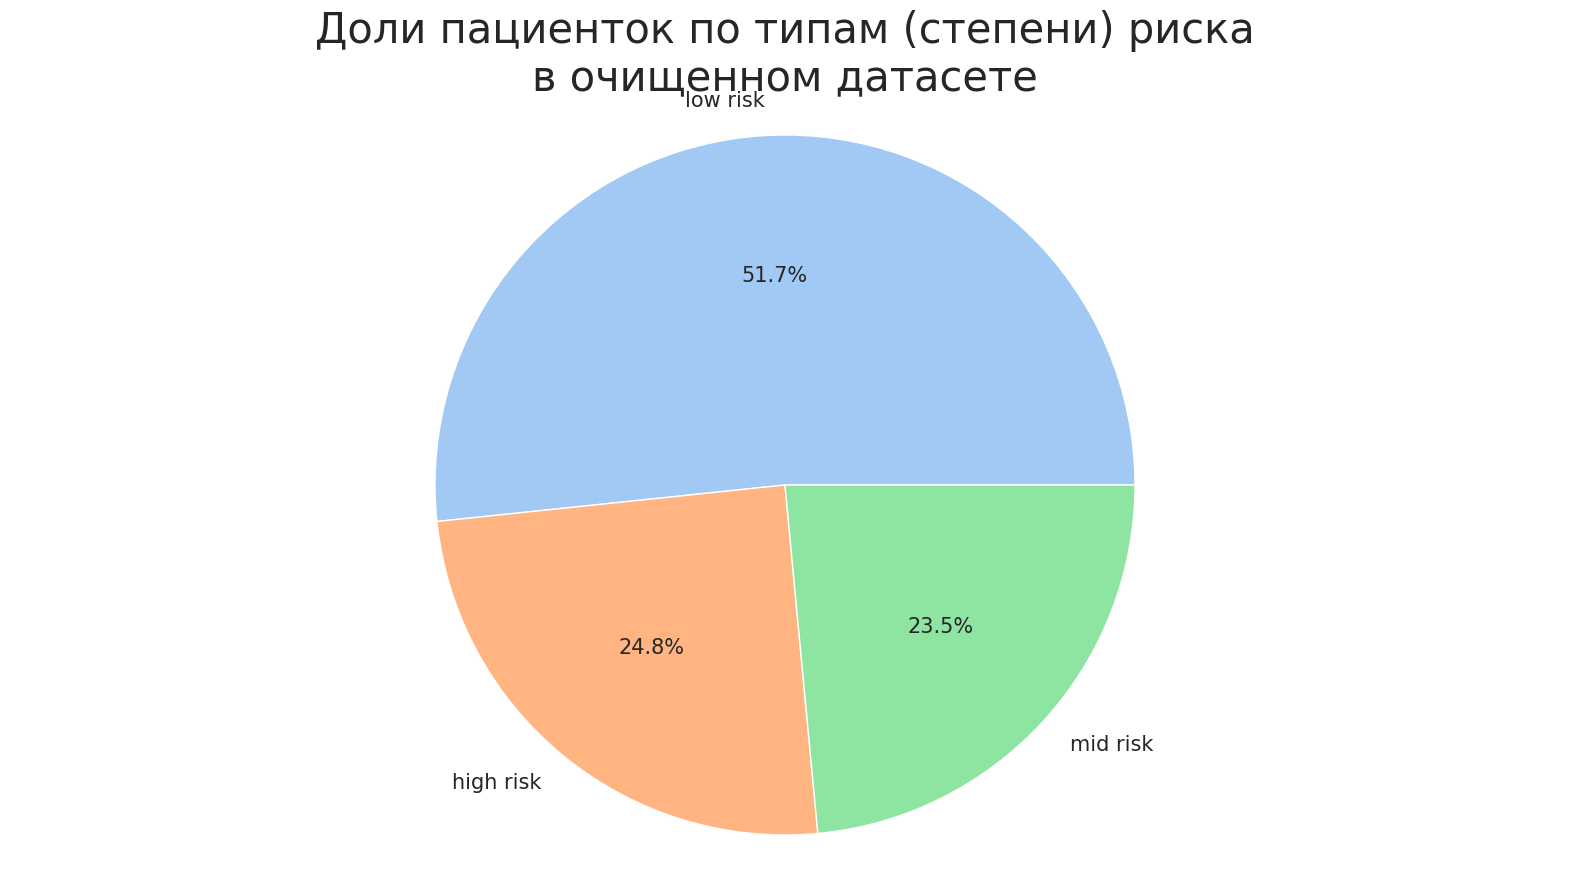

In [ ]:
# визуализируем целевой признак в очищенном датасете
risk_drop['RiskLevel'].value_counts().plot(kind = 'pie', grid = True,\
                                     figsize = (20,10), fontsize=15, autopct='%1.1f%%')

plt.title('Доли пациенток по типам (степени) риска\nв очищенном датасете', fontsize=30)
plt.axis('equal')
plt.ylabel('', fontsize=13)

plt.show()

Баланс классов сместился: доля пациенток с низким риском увеличилась, а доли среднего и высокого - уменьшились.

Однако "небезопасные" доли по-прежнему велики, и составляют чуть меньше четверти данных каждая (и почти половину - вместе, то есть немного меньше "безопасной"), что хорошо характеризует нашу выборку в плане представленности классов.

Теперь выведу матрицу корреляции.

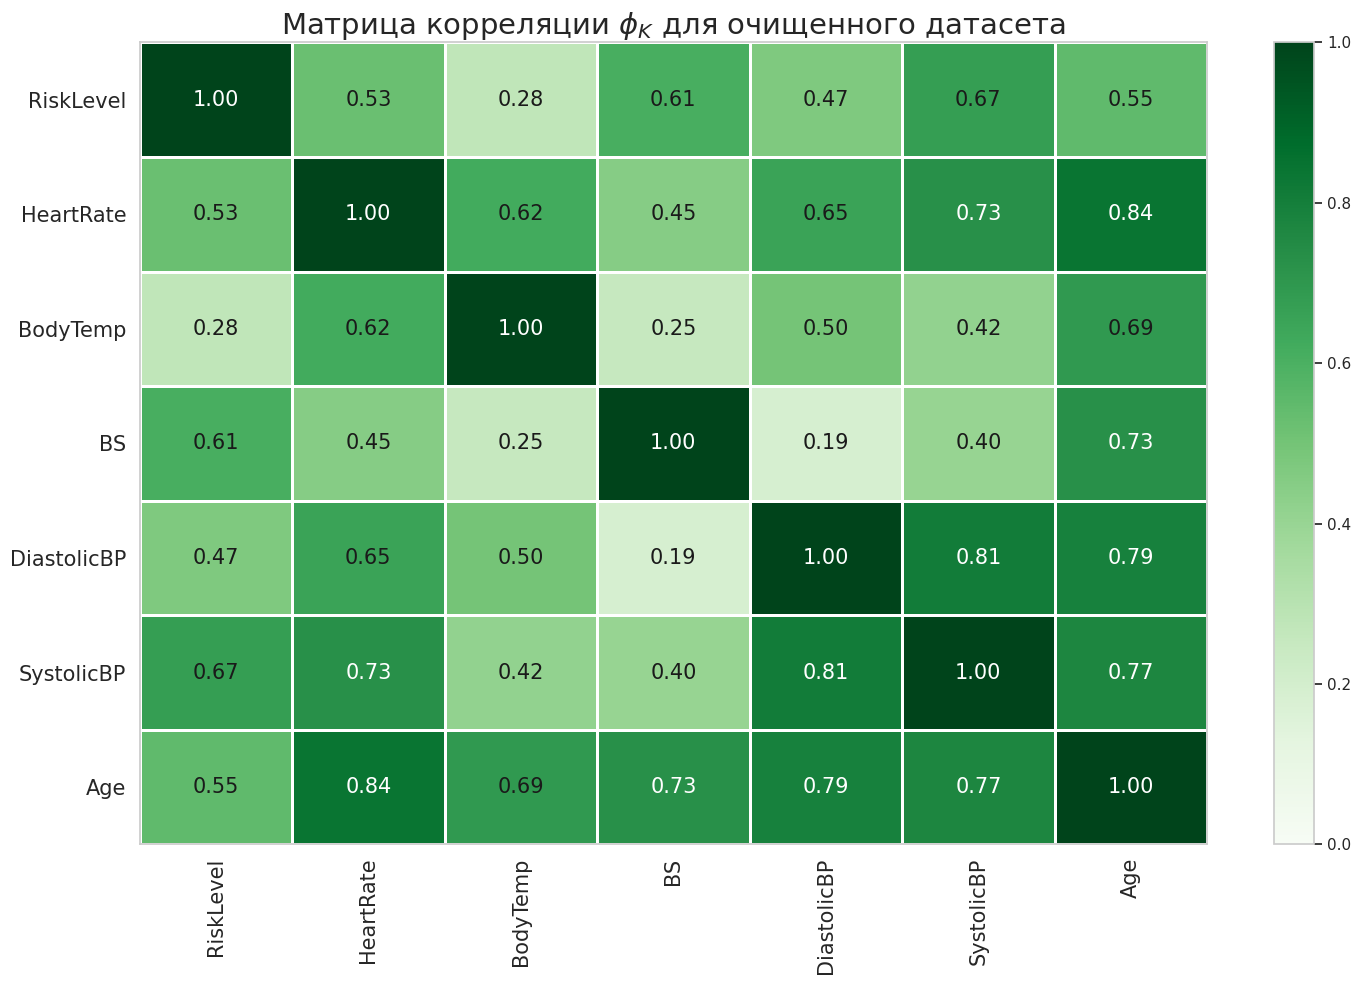

In [ ]:
# считаем корреляции
phik_overview_drop = risk_drop.phik_matrix(interval_cols=interval_cols)

# матрица корреляции
plot_correlation_matrix(
    phik_overview_drop.values,
    x_labels=phik_overview_drop.columns,
    y_labels=phik_overview_drop.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции $\phi_K$ для очищенного датасета',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Связь температуры тела и целевого признака несколько усилилась (и ее по-прежнему нельзя удалять ввиду этого). А вот связь возраста и целевого признака стала слабее.

Но при этом по-прежнему самые тестные связи с остальными признаками у возраста и частоты сердечного ритма остались.

Самая слабая связь - между диастолическим давлением и уровнем глюкозы в крови.

Теперь, когда данные очищены и исследованы, можно переходить к их дальнейшей подготовке для исследований.


#### **Выводы**

Я очистила исходный датасет от выбросов и явных дубликатов, о после кратко исследовала его:

- Статистический анализ очищенного датасета показал, что:
  - Диапазоны значений нормальности либо не изменились, либо чуть сузились за счет уменьшения верхнего предела нормы (исключение - систолическое давление, у которого диапазон напротив чуть расширился).
  - Медианы не изменились (лишь у возраста увеличислась на год).
  - При сравнении разлиных статистических показателей можно утверждать, что очищенный датасет в некотором роде близок к исходному.

Исследование баланс классов показало, что:
- Баланс классов сместился: доля пациенток с низким риском увеличилась, а доли среднего и высокого - уменьшились.
- "Небезопасные" доли по-прежнему велики, и составляют чуть меньше четверти данных каждая, что хорошо характеризует нашу выборку в плане представленности классов.

- Матрица корреляции очищенной корреляции показала, что:
  - Связь температуры тела и целевого признака несколько усилилась.
  - Cвязь возраста и целевого признака стала слабее.
  - Cамые тесные связи с остальными признаками по-прежнему у возраста и частоты сердечного ритма.
  - Самая слабая связь - между диастолическим даволением и уровнем глюкозы в крови.


## **Подготовка работы с моделями**

### **Работа с целевым признаком**

In [ ]:
# задаем целевой признак
target = 'RiskLevel'

Целевой признак имеет три варианта значения, имеющих иерархию и выраженными словесно.

Преобразовать целевой признак в понятный модели вариант можно с помощью LabelEncoder (но он может нарушить порядок, который здесь важен), или с помощью ORD. Но проще будет преобразовать целевой признак с помощью маппинга.

In [ ]:
# сохраняем mapping-и для последующего использования

# сохраняем mapping с явным заданием порядка для кодирования
RISK_MAPPING = {
    'low risk': 0,
    'mid risk': 1,
    'high risk': 2
}
# сохраняем обратный mapping для интерпритации результатов
INVERSE_RISK_MAPPING = {v: k for k, v in RISK_MAPPING.items()}

In [ ]:
# выводим первые строки непреобразованного датасета
# для будущего сравнения
risk_drop.head(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.00,86,high risk
1,35,140,90,13.00,98.00,70,high risk
2,29,90,70,8.00,100.00,80,high risk
3,30,140,85,7.00,98.00,70,high risk
4,35,120,60,6.10,98.00,76,low risk
5,23,140,80,7.01,98.00,70,high risk
6,23,130,70,7.01,98.00,78,mid risk
7,35,85,60,11.00,102.00,86,high risk
8,32,120,90,6.90,98.00,70,mid risk
9,42,130,80,18.00,98.00,70,high risk


In [ ]:
# преобразуем целевой признак
risk_drop[target] = risk_drop[target].map(RISK_MAPPING)

# выводим первые строки преобразованного датасета
# для сравнения
risk_drop.head(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.00,86,2
1,35,140,90,13.00,98.00,70,2
2,29,90,70,8.00,100.00,80,2
3,30,140,85,7.00,98.00,70,2
4,35,120,60,6.10,98.00,76,0
5,23,140,80,7.01,98.00,70,2
6,23,130,70,7.01,98.00,78,1
7,35,85,60,11.00,102.00,86,2
8,32,120,90,6.90,98.00,70,1
9,42,130,80,18.00,98.00,70,2


Преобразование прошло корректно.

Стандартизацию же (масштабировние) числовых признаков я буду производить уже непосредственно при работе с моделями в случае необходимости (так как, например, модели, основанные на деревьях решений, не требуют такой подготовки).

### **Разбиение на выборки**

Теперь данные необходимо разбить на выборки.

In [ ]:
# функция подготовки данных перед подбором моделей и их параметров
# вариант 1 (модифицированный)
def data_preprocessing(data, target_name):

    # Перемешивание объектов
    # для их лучшего распределения в выборках
    data = shuffle(data, random_state=RANDOM_STATE)

    # Разделение датафреймов на целевую и нецелевую выборку
    features = data.drop([target_name], axis=1)
    target = data[target_name]

    # Разделение целевой и нецелевой выборки
    # на обучающие и тестовые выборки
    X_train,  X_test, y_train, y_test = train_test_split(
        features,
        target,
        shuffle = True, # перемешивание, больше нужно для задач классификации
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        # учтем неравномерность выборки по целевому
        stratify=data[target_name] # стратификация по указанному признаку
    )

    return X_train, X_test, y_train, y_test

In [ ]:
# разделение обучающего датафрейма на целевую и тестовую выборку
X_train, X_test, y_train, y_test = data_preprocessing(risk_drop, target)

In [ ]:
# проверка разбиения по количеству
print(color.BLUE + color.BOLD + f"Размер X_train: "\
      + color.END + f"{X_train.shape}")
print(color.BLUE + color.BOLD + f"Размер X_test: "\
      + color.END + f"{X_test.shape}")
print(color.BLUE + color.BOLD + f"Размер y_train: "\
      + color.END + f"{y_train.shape}")
print(color.BLUE + color.BOLD + f"Размер y_test: "\
      + color.END + f"{y_test.shape}")

Размер X_train: (338, 6)
Размер X_test: (113, 6)
Размер y_train: (338,)
Размер y_test: (113,)


In [ ]:
# проверка разбиения по качеству

# проверка разбиения по долям
print(color.BLUE + color.BOLD + f'Доля тренировочных признаков: '\
      + color.END + f'{X_train.shape[0]/risk_drop.shape[0]:.2f}')
print(color.BLUE + color.BOLD + f'Доля тренировочных целей: '\
      + color.END + f'{y_train.shape[0]/risk_drop.shape[0]:.2f}')
print(color.BLUE + color.BOLD + f'Доля тестовых признаков: '\
      + color.END + f'{X_test.shape[0]/risk_drop.shape[0]:.2f}')
print(color.BLUE + color.BOLD + f'Доля тестовых целей: '\
      + color.END + f'{y_test.shape[0]/risk_drop.shape[0]:.2f}')

# смотрим доли целевого признака (с обратным маппингом)
print(color.BLUE + color.BOLD + 'Распределение классов в тренировочных данных:' + color.END)
for class_id, class_name in INVERSE_RISK_MAPPING.items():
    proportion = (y_train == class_id).mean()
    print(f'{class_name}: {proportion:.2%}')
print(color.BLUE + color.BOLD + 'Распределение классов в тестовых данных:' + color.END)
for class_id, class_name in INVERSE_RISK_MAPPING.items():
    proportion = (y_test == class_id).mean()
    print(f'{class_name}: {proportion:.2%}')

Доля тренировочных признаков: 0.75
Доля тренировочных целей: 0.75
Доля тестовых признаков: 0.25
Доля тестовых целей: 0.25
Распределение классов в тренировочных данных:
low risk: 51.78%
mid risk: 23.37%
high risk: 24.85%
Распределение классов в тестовых данных:
low risk: 51.33%
mid risk: 23.89%
high risk: 24.78%


Разбиение на выборки прошло успешно.

### **Выбор метрики**

Для того, чтобы узнать, насколько хороша или плоха модель, необходимо использовать метрику для оценки качества модели. В условиях задачи она не указано, но есть требование выбрать самостоятельно.

Данная задача - задача классификации с тремя несбалансированными классами, которые имеют порядок. Поэтому оптимальной (основной) метрикой для нее станет QWK, а дополнительной - Macro F1-score.

> **Quadratic Weighted Kappa (QWK)** - является стандартной метрикой в соревнованиях с порядковой классификацией. Она измеряет согласие между двумя экспертами (в данном случае - между истинными значениями и предсказаниями модели), учитывая серьезность разногласий.
>Формула для расчёта QWK включает в себя взвешенную сумму квадратов разностей между предсказанными и фактическими значениями, что позволяет учитывать степень несоответствия между оценками. Веса обычно задаются в виде матрицы, где больший вес присваивается более серьёзным ошибкам.
>Преимущества метрики:
> - Учитывает порядок: Ошибка "низкий→высокий" хуже, чем "низкий→средний";
> - Учитывает дисбаланс (не наприямую, но адаптируется): Не завышена из-за majority-класса;
> - Чувствительна: Различает качество моделей лучше accuracy;
> - Интерпретируема: Понятная шкала от -1 до 1:
    - 1.0: Полное согласие (идеальная модель);
    - 0.8-0.9: Отличное согласие;
    - 0.6-0.8: Хорошее согласие;
    - 0.4-0.6: Умеренное согласие;
    - 0.2-0.4: Слабое согласие;
    - < 0.2: Плохое согласие;
    - < 0: Хуже случайного угадывания.

> **F1-score (F-мера)** - гармоническое среднее между Precision и Recal. Важна, когда нужен баланс между этими двумя метриками и когда классы несбалансированы.
> **Macro F1-score** - это среднее арифметическое F1-score по всем классам, где каждый класс имеет одинаковый вес независимо от его размера.
> Преимущества метрики:
> - Учитывает дисбаланс - не завышена из-за majority-класса;
> - Справедлива к малым классам - каждый класс имеет одинаковый вес;
> - Баланс precision/recall - учитывает и false positive, и false negative;
> - Интерпретируема - понятная шкала от 0 до 1:
>
>|Диапазон Macro F1|Интерпретация|Качество модели|
>|-------------|-------------|-------------|
>|0.90 - 1.00|Отличное|Почти идеальные предсказания|
>|0.80 - 0.89|Очень хорошее|Высокое качество|
>|0.70 - 0.79|Хорошее|Solid performance|
>|0.60 - 0.69|Удовлетворительное|Приемлемое качество|
>|0.50 - 0.59|Слабое|Нуждается в улучшении|
>|0.40 - 0.49|Плохое|Требует серьезной доработки|
>|0.30 - 0.39|Очень плохое|Почти бесполезная модель|
>|0.00 - 0.29|Катастрофическое|Хуже базовых эвристик|
>
>Однако интерпретация имеет особенности, например:
>1. Зависит от количества классов:
>      - Для 2 классов случайное угадывание: ~0.5;
>      - Для 3 классов случайное угадывание: ~0.33;
>      - Для 4 классов случайное угадывание: ~0.25.
>2. Более строгая, чем accuracy:
>      - Macro F1 всегда ≤ accuracy на несбалансированных данных;
>      - Требует хорошего качества по всем классам, чувствительна к выбросам;
>3. Контекстно-зависимая:
>      -  В медицине: приемлемо от 0.7+
>      -  В рекомендательных системах: от 0.6+
>      -  В научных исследованиях: от 0.8+

Возможно, уже на тестовых данных, я также кроме требуемой в задании матрицы ошибок, дополнительно взгляну и на иные метрики для лучшей оценки качества.

Задам метрику для дальнейшего многоразового применения в моделях.






In [ ]:
# создаем официальную метрику для sklearn
# Quadratic Weighted Kappa для кросс-валидации
QWK_SCORER = make_scorer(
    lambda y_true, y_pred: cohen_kappa_score(y_true, y_pred, weights='quadratic'),
    greater_is_better=True
)

### **Выводы**

В данном разделе я:
- Задала целевой признак через переменную для удобства дальнейшей работы;
- Перевела значения целевого признака в понятный для модели вид с учетом иерархии категорий;
- Разбила данные на выборки с учетом дисбаланса классов;
- С учетом особенностей данных выбрала метрики: QWK как основную и Macro F1-score как дополнительную, а также задала одну из них через make_scorer для удобства многоразового применения.

Масштабирование же числовых признаков я буду производить уже непосредственно при работе с моделями при необходимости.

## Работа с моделями

Данная задача - задача мультиклассовой классификации, причем классы имеют порядок. Принадлежность задачи к задачам классификации и небольшой размер итогового датасета дает возможность испытать большое количество моделей. Однако количество категорий больше двух и наличие в них порядка могут накладывать ограничения на работу моделей и уровень качества.

Я выбрала для работы следующие модели:

- Модели для сравнения:
  - DummyClassifier - как самую "глупую" модель, для сравнения с остальными;
  - LogisticRegression - как "самую простую", в качестве "дополнительной базовой" (чтобы сравнивать не только с Dummy).

- "Простые модели:"
  - KNN (k-Nearest Neighbors);
  - SVM (Support Vector Machine);
  - Decision Tree.
- Ассамблевые:
  - RandomForest;
  - LGBM (LightGBM);
  - CatBoost.

Так как данные представленны таблицами (а не текстом или изображением), то классические модели в большинстве случаев справляются с такими данными лучше, чем нейронные сети (поэтому сети, которые, к тому же, потребляют больше ресурсов, применять не буду).

Для хранения результатов для удобного сравнения моделей создам словарь.

In [ ]:
# создаем словарь для сравнения
models_dict = {}

### **Обучение моделей**

#### **Dummy-модель**

Базовая, необходима для более объективного сравнения качества лучших моделей.

>**DummyClassifier** — это классификатор, который предсказывает класс на основе стратегии, заданной пользователем (например, выбор наиболее частого класса или случайное предсказание). Используется в основном для получения базового уровня точности, с которым можно сравнивать другие модели.

По результатам работы функции получим метрику QWD на кросс-валидации (как основную), и дополнительно QWD и Macro F1-score для лучшей модели на тренировочных данных без кросс-валидации (эта QWD с большой долей вероятности будет завышна относительно QWD с кросс-валидацией, но она нужна для того, чтобы иметь одинаковые условия с Macro F1-score для коректноти оценки и дополнительной возможности увидеть склонность модели к переобучению).

Вероятно, функция ниже является черезчур громоздкой для Dummy-модели, но она является образцом для построения остальных моделей, поэтому я решила реализовать ее именно в таком виде.

Теоретически, можно было бы вынести создание cv (кросс-валидации с фиксированным random_state) за пределы функции (и иметь возможность использовать готовую многократно в упрощенном виде), но оставлю внутри для возможности менять количество фолдов в случае необходимости (чтобы в разных моделях можно было сделать разные).

In [ ]:
def Dummy_Classifier(X_train, y_train):
    """
    функция с дамми-моделью для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.
    """
    # инициализация модели
    model = DummyClassifier(random_state=RANDOM_STATE)

    # определение сетки гиперпараметров
    param_grid = {
        'strategy': ['most_frequent', # предсказывает самый частый класс
                     'prior', # предсказывает классы пропорционально их частоте
                     'stratified', # случайно, но с сохранением распределения классов
                     'uniform'] # случайно с равной вероятностью
    }

    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, # количество фолдов для кросс-валидации
                         shuffle=True, # перемешивание данных
                         random_state=RANDOM_STATE) # фиксация рандома

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        model, # модель
        param_grid, # параметры
        scoring=QWK_SCORER, # метрика
        refit=False,  # НЕ переобучаем модель сразу, чтобы замерить время отдельно
        n_jobs=-1,  # все ядра
        cv=cv, # фолды для кросс-валидации
        verbose=1 # не отключаем вывод
    )

    # обучение GridSearchCV (только поиск по параметрам)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = DummyClassifier(random_state=RANDOM_STATE, **best_params)
    best_model.fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # Анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model, # лучшая модель
        'best_qwk_cv': best_qwk_score, # лучшая QWK при CV (для сравнения стратегий)
        'qwk_train': qwk_train, # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train, # Macro F1 на тренировочных данных
        'best_params': best_params, # лучшие параметры
        'best_model_time': best_model_time, # время обучения только лучшей модели
        #'grid_search': grid_search  # если нужно сохранить объект GridSearchCV
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time dummy_results = Dummy_Classifier(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Лучшая QWK при CV: 0.0781
QWK на тренировочных данных: -0.0405
Macro F1 на тренировочных данных: 0.3214
Лучшие параметры: {'strategy': 'stratified'}
Время обучения лучшей модели: 0.0006 секунд

Распределение предсказаний:
Класс 0: 170 предсказаний (50.3%)
Класс 1: 85 предсказаний (25.1%)
Класс 2: 83 предсказаний (24.6%)
CPU times: user 39.8 ms, sys: 358 µs, total: 40.2 ms
Wall time: 183 ms


Данная модель просто ужасна. Но теперь у меня есть базовые значения, которые можно использовать для дальнейшей оценки.

Внесу их в словарь. Так как основной метрикой для сравнения выбрана QWK на кросс-валидации, то сохранять буду ее.

In [ ]:
# добавляем в словарь
models_dict['Dummy_Classifier'] = {
    'QWK_CV': round(dummy_results['best_qwk_cv'], 4),
    'best_model_time': dummy_results['best_model_time'],
    'params': dummy_results['best_params']
}

In [ ]:
# проверяем словарь
pd.DataFrame.from_dict(models_dict, orient = 'index')

,QWK_CV,best_model_time,params
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}


Перейду к следующей модели.

#### **LogisticRegression**

Начну с простой модели - Логистической регресии.

>**LogisticRegression** — это модель для решения задач бинарной и мультиклассовой классификации, которая использует логистическую функцию для оценки вероятности принадлежности объекта к определённому классу.

С учетом плохих показателей, полученных Dummy-моделью ("глупая модель"), Логистическая регресия также может выступить в роли "второй базовой", с которой будут сравниваться остальные "умные модели".

Она требует подготовки числовых данных (масштабирование) которое я проведу внутри функции с моделью.

In [ ]:
# создаем функцию по образцу выше для логистической регрессии
# с учетом того, что нам нужно только масштабирование
def LogisticRegression_Classifier(X_train, y_train):
    """
    функция с Логистической регрессией для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с обработкой пропусков и масштабированием числовых признаков;
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.

    """
    # создаем пайплайн с обработкой пропусков и стандартизацией
    pipe_lr = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # обработка пропусков
        ('scaler', StandardScaler()),  # стандартизация, важна для линейных моделей
        ('logisticregression', LogisticRegression(random_state=RANDOM_STATE, # фиксация рандома
                                                  # опционально: чтобы избежать небольшой warning в конце
                                                  # можно убрать строку ниже (multi_class='multinomial' теперь по умолчанию)
                                                  multi_class='multinomial')) # мультиклассовая порядковая классификация

    ])

    # определение сетки гиперпараметров
    # сетка параметров ТОЛЬКО для multinomial-совместимых solver
    param_grid = [
        # для solver='saga' - поддерживает все penalty
        {
            'logisticregression__penalty': ['l1', 'l2', None],
            'logisticregression__C': [0.01, 0.1, 1, 10],
            'logisticregression__solver': ['saga'],
            'logisticregression__max_iter': [100, 200]
        },
        # для solver='lbfgs' и 'newton-cg' - только l2 и None
        {
            'logisticregression__penalty': ['l2', None],
            'logisticregression__C': [0.01, 0.1, 1, 10],
            'logisticregression__solver': ['lbfgs', 'newton-cg'],
            'logisticregression__max_iter': [100, 200]
        }
    ]

    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, # количество фолдов для кросс-валидации
                         shuffle=True, # перемешивание данных
                         random_state=RANDOM_STATE) # фиксация рандома

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_lr, # модель-пайплайн
        param_grid=param_grid, # параметры
        scoring=QWK_SCORER, # метрика
        refit=False,  # НЕ переобучаем модель сразу, чтобы замерить время отдельно
        n_jobs=-1,  # все ядра
        cv=cv, # # фолды для кросс-валидации
        verbose=1, # не отключаем вывод
    )

   # обучение GridSearchCV (только поиск по параметрам)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = pipe_lr.set_params(**grid_search.best_params_).fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model, # лучшая модель
        'best_qwk_cv': best_qwk_score, # лучшая QWK при CV (для сравнения стратегий)
        'qwk_train': qwk_train, # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train, # Macro F1 на тренировочных данных
        'best_params': best_params, # лучшие параметры
        'best_model_time': best_model_time, # время обучения только лучшей модели
        #'grid_search': grid_search  # если нужно сохранить объект GridSearchCV
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time lr_results = LogisticRegression_Classifier(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits

Лучшая QWK при CV: 0.5729
QWK на тренировочных данных: 0.5994
Macro F1 на тренировочных данных: 0.5664
Лучшие параметры: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}
Время обучения лучшей модели: 0.0093 секунд

Распределение предсказаний:
Класс 0: 236 предсказаний (69.8%)
Класс 1: 28 предсказаний (8.3%)
Класс 2: 74 предсказаний (21.9%)
CPU times: user 360 ms, sys: 10.3 ms, total: 370 ms
Wall time: 4.61 s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Модель дает гораздо лучшие результаты, чем Dummy-модель. Но качество ее умеренное.

Внесу данные в словарь.

In [ ]:
# добавляем в словарь
models_dict['LogisticRegression_Classifier'] = {
    'QWK_CV': round(lr_results['best_qwk_cv'], 4),
    'best_model_time': lr_results['best_model_time'],
    'params': lr_results['best_params']
}

In [ ]:
# проверяем словарь
pd.DataFrame.from_dict(models_dict, orient = 'index')

,QWK_CV,best_model_time,params
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}
LogisticRegression_Classifier,0.57,0.01,"{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}"


#### **KNN**

Испытаю еще одну модель: k ближайших соседей. Возможно, она сможеть дать лучший результат, чем Логистическая регрессия.

>**KNN (k-Nearest Neighbors)** — это метод классификации и регрессии, основанный на поиске k ближайших соседей объекта в пространстве признаков и принятии решения на основе их меток или среднего значения (в случае регрессии).

In [ ]:
# создаем функцию по образцу выше для K ближайших соседей
def KNN_Classifier(X_train, y_train):
    """
    функция с KNN для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с обработкой пропусков и масштабированием числовых признаков;
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.
    """

    # создаем пайплайн с обработкой пропусков и стандартизацией
    pipe_knn = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # обработка пропусков
        ('scaler', StandardScaler()),  # стандартизация (КРИТИЧНО для KNN!)
        ('knn', KNeighborsClassifier()) # random_state не нужен для KNN, модель детерминирована
    ])

    # определение сетки гиперпараметров для KNN
    param_grid = {
        'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 21],  # количество соседей
        'knn__weights': ['uniform', 'distance'],  # вес соседей
        'knn__p': [1, 2]  # метрика расстояния (1=манхэттен, 2=евклидово)
    }

    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_knn, # модель-пайплайн
        param_grid=param_grid, # параметры
        scoring=QWK_SCORER, # метрика
        refit=False, # НЕ переобучаем модель сразу, чтобы замерить время отдельно
        n_jobs=-1, # все ядра
        cv=cv,  # фолды для кросс-валидации
        verbose=1
    )

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_knn,  # модель-пайплайн
        param_grid=param_grid,  # параметры
        scoring=QWK_SCORER,  # метрика
        refit=False,  # НЕ переобучаем модель сразу, чтобы замерить время отдельно
        n_jobs=-1,  # все ядра
        cv=5,  # количество фолдов для кросс-валидации
        verbose=1  # не отключаем вывод
    )

    # обучение GridSearchCV (только поиск по параметрам)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = pipe_knn.set_params(**grid_search.best_params_).fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model,  # лучшая модель
        'best_qwk_cv': best_qwk_score,  # лучшая QWK при CV
        'qwk_train': qwk_train,  # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train,  # Macro F1 на тренировочных данных
        'best_params': best_params,  # лучшие параметры
        'best_model_time': best_model_time,  # время обучения только лучшей модели
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time knn_results = KNN_Classifier(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits

Лучшая QWK при CV: 0.6475
QWK на тренировочных данных: 0.6965
Macro F1 на тренировочных данных: 0.6189
Лучшие параметры: {'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}
Время обучения лучшей модели: 0.0054 секунд

Распределение предсказаний:
Класс 0: 221 предсказаний (65.4%)
Класс 1: 39 предсказаний (11.5%)
Класс 2: 78 предсказаний (23.1%)
CPU times: user 176 ms, sys: 6.53 ms, total: 182 ms
Wall time: 1.24 s


Показатель главной метрики улучшились. Внесу в словарь.

In [ ]:
# добавляем в словарь
models_dict['KNN_Classifier'] = {
    'QWK_CV': round(knn_results['best_qwk_cv'], 4),
    'best_model_time': knn_results['best_model_time'],
    'params': knn_results['best_params']
}

In [ ]:
# проверяем словарь
pd.DataFrame.from_dict(models_dict, orient = 'index')

,QWK_CV,best_model_time,params
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}
LogisticRegression_Classifier,0.57,0.01,"{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}"
KNN_Classifier,0.65,0.01,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}"


#### **SVM**

Метод обычно ресурсоемкий, но так как датасет небольшой, можно испытать и его.

>**SVM (Support Vector Machine)** — это модель для классификации и регрессии, которая ищет гиперплоскость в пространстве признаков, наилучшим образом разделяющую данные на классы. Основная идея заключается в максимизации ширины разделяющей полосы между классами, что способствует лучшей обобщающей способности модели.

In [ ]:
# создаем функцию по образцу выше для метода опорных векторов
# требует масштабирования, может быть медленным на больших датасетах
def SVM_Classifier(X_train, y_train):
    """
    функция с SVM для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с обработкой пропусков и масштабированием числовых признаков (КРИТИЧНО для SVM);
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.
    """

    # создаем пайплайн с обработкой пропусков и стандартизацией (КРИТИЧНО для SVM!)
    pipe_svm = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # обработка пропусков
        ('scaler', StandardScaler()),  # стандартизация - ОБЯЗАТЕЛЬНО для SVM!
        ('svm', SVC(random_state=RANDOM_STATE,  # фиксация рандома
                    probability=True))  # чтобы можно было получать вероятности
    ])

    # определение сетки гиперпараметров для SVM
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],  # параметр регуляризации
        'svm__kernel': ['linear', 'rbf', 'poly'],  # ядро
        'svm__gamma': ['scale', 'auto', 0.1, 1],  # параметр для rbf/poly
        'svm__degree': [2, 3]  # степень для poly ядра
    }

    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_svm,  # модель-пайплайн
        param_grid=param_grid,  # параметры
        scoring=QWK_SCORER,  # метрика
        refit=False,  # НЕ переобучаем модель сразу
        n_jobs=-1,  # все ядра
        cv=cv,  # фолды для кросс-валидации
        verbose=1  # не отключаем вывод
    )

    # обучение GridSearchCV (только поиск по параметрам)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = pipe_svm.set_params(**best_params).fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model,  # лучшая модель
        'best_qwk_cv': best_qwk_score,  # лучшая QWK при CV
        'qwk_train': qwk_train,  # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train,  # Macro F1 на тренировочных данных
        'best_params': best_params,  # лучшие параметры
        'best_model_time': best_model_time,  # время обучения только лучшей модели
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time svm_results = SVM_Classifier(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Лучшая QWK при CV: 0.6599
QWK на тренировочных данных: 0.7080
Macro F1 на тренировочных данных: 0.6457
Лучшие параметры: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Время обучения лучшей модели: 0.0274 секунд

Распределение предсказаний:
Класс 0: 220 предсказаний (65.1%)
Класс 1: 34 предсказаний (10.1%)
Класс 2: 84 предсказаний (24.9%)
CPU times: user 1.12 s, sys: 50 ms, total: 1.17 s
Wall time: 1min 30s


Главная метрика чуть лучше, чем у KNN, но обучение лучшей модели идет дольше.

In [ ]:
# добавляем в словарь
models_dict['SVM_Classifier'] = {
    'QWK_CV': round(svm_results['best_qwk_cv'], 4),
    'best_model_time': svm_results['best_model_time'],
    'params': svm_results['best_params']
}

In [ ]:
# проверяем словарь
pd.DataFrame.from_dict(models_dict, orient = 'index')

,QWK_CV,best_model_time,params
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}
LogisticRegression_Classifier,0.57,0.01,"{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}"
KNN_Classifier,0.65,0.01,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}"
SVM_Classifier,0.66,0.03,"{'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"


#### **DecisionTreeClassifier**

Испытаю одиночное Дерево решений.

>**Decision Tree** — это модель, представляющая собой дерево решений, где каждый узел представляет собой проверку на атрибут, каждая ветвь — результат этой проверки, а каждый лист — метка класса. Деревья решений используются для классификации и регрессии.

Основанные на деревьях модели не требуют обязательного масштабирования числовых признаков, учту это при адаптации функции.

In [ ]:
# создаем функцию по образцу для дерева решений
# учтем, что модели, основанные на деревьях, не требуют дополнительного масштабирования
def DecisionTree_Classifier(X_train, y_train):
    """
    функция с Decision Tree для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с обработкой пропусков (масштабирование не нужно для деревьев);
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.
    """

    # создаем пайплайн только с обработкой пропусков (масштабирование не нужно для деревьев)
    pipe_dt = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # обработка пропусков
        ('decisiontree', DecisionTreeClassifier(random_state=RANDOM_STATE))  # фиксация рандома
    ])

    # определение сетки гиперпараметров для Decision Tree
    param_grid = {
        'decisiontree__criterion': ['gini', 'entropy'],  # критерий разделения
        'decisiontree__max_depth': [None, 10, 15, 20],  # максимальная глубина
        'decisiontree__min_samples_split': [5, 10, 20],  # минимальное количество samples для разделения
        #'decisiontree__min_samples_leaf': [2, 4, 8],  # минимальное количество samples в листе
        'decisiontree__max_features': [None, 'sqrt', 'log2', 0.5, 0.8],  # количество features для разделения
    }

    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_dt,  # модель-пайплайн
        param_grid=param_grid,  # параметры
        scoring=QWK_SCORER,  # метрика
        refit=False,  # НЕ переобучаем модель сразу
        n_jobs=-1,  # все ядра
        cv=cv,  # фолды для кросс-валидации
        verbose=1  # не отключаем вывод
    )

    # обучение GridSearchCV (только поиск по параметров)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = pipe_dt.set_params(**best_params).fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model,  # лучшая модель
        'best_qwk_cv': best_qwk_score,  # лучшая QWK при CV
        'qwk_train': qwk_train,  # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train,  # Macro F1 на тренировочных данных
        'best_params': best_params,  # лучшие параметры
        'best_model_time': best_model_time,  # время обучения только лучшей модели
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time dt_results = DecisionTree_Classifier(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Лучшая QWK при CV: 0.6946
QWK на тренировочных данных: 0.8709
Macro F1 на тренировочных данных: 0.8549
Лучшие параметры: {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 10, 'decisiontree__max_features': 0.8, 'decisiontree__min_samples_split': 5}
Время обучения лучшей модели: 0.0063 секунд

Распределение предсказаний:
Класс 0: 199 предсказаний (58.9%)
Класс 1: 60 предсказаний (17.8%)
Класс 2: 79 предсказаний (23.4%)
CPU times: user 535 ms, sys: 12.7 ms, total: 548 ms
Wall time: 5.72 s


Относительно предыдущих моделей главная метрика подросла, а относительно SVM время обучения лучшей модели - снизилось.

Также обученная на всех данных модель показывает достаточно хорошие обе метрики, но разница с кросс-валидационной указывает на склонность к переобучению.

In [ ]:
# добавляем в словарь
models_dict['DecisionTree_Classifier'] = {
    'QWK_CV': round(dt_results['best_qwk_cv'], 4),
    'best_model_time': dt_results['best_model_time'],
    'params': dt_results['best_params']
}

In [ ]:
# проверяем словарь
pd.DataFrame.from_dict(models_dict, orient = 'index')

,QWK_CV,best_model_time,params
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}
LogisticRegression_Classifier,0.57,0.01,"{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}"
KNN_Classifier,0.65,0.01,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}"
SVM_Classifier,0.66,0.03,"{'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
DecisionTree_Classifier,0.69,0.01,"{'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 10, 'decisiontree__max_features': 0.8, 'decisiontree__min_samples_split': 5}"


#### **RandomForest**

Попробую ассамблевую модель. Одиночное Дерево решений уже проверено и дало лучшую метрику среди "обычных" моделей. Возможно, Лес справиться лучше?

>**RandomForest** — это ансамбль деревьев решений, где каждое дерево строится на случайной подвыборке данных и случайных подмножествах признаков. Модель объединяет прогнозы всех деревьев для повышения точности и устойчивости к переобучению. (т.е. использует бэггинг).

In [ ]:
# создаем функцию по образцу для случайного леса
# учтем, что модели, основанные на деревьях, не требуют дополнительного масштабирования
def RandomForest_Classifier(X_train, y_train):
    """
    функция со Случайным лесом для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с обработкой пропусков (масштабирование не нужно для деревьев);
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.
    """

    # создаем пайплайн только с обработкой пропусков (масштабирование не нужно для деревьев)
    pipe_rf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # обработка пропусков
        ('randomforest', RandomForestClassifier(random_state=RANDOM_STATE))  # фиксация рандома
    ])

    # определение сетки гиперпараметров для Random Forest
    param_grid = {
      'randomforest__n_estimators': [50, 100],  # количество деревьев
      'randomforest__criterion': ['gini', 'entropy'],  # критерий разделения
      'randomforest__max_depth': [10, 20],  # максимальная глубина, None может способствовать переобучению
      'randomforest__min_samples_split': [5, 10],  # минимальное количество samples для разделения
      'randomforest__min_samples_leaf': [1, 2, 4],  # минимальное количество samples в листе
      'randomforest__max_features': ['sqrt', 'log2']  # количество features для разделения, None может способствовать переобучению
    }


    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_rf,  # модель-пайплайн
        param_grid=param_grid,  # параметры
        scoring=QWK_SCORER,  # метрика
        refit=False,  # НЕ переобучаем модель сразу
        n_jobs=-1,  # все ядра
        cv=cv,  # фолды для кросс-валидации
        verbose=1  # не отключаем вывод
    )

    # обучение GridSearchCV (только поиск по параметрам)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = pipe_rf.set_params(**best_params).fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model,  # лучшая модель
        'best_qwk_cv': best_qwk_score,  # лучшая QWK при CV
        'qwk_train': qwk_train,  # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train,  # Macro F1 на тренировочных данных
        'best_params': best_params,  # лучшие параметры
        'best_model_time': best_model_time,  # время обучения только лучшей модели
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time rf_results = RandomForest_Classifier(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Лучшая QWK при CV: 0.7025
QWK на тренировочных данных: 0.8408
Macro F1 на тренировочных данных: 0.8218
Лучшие параметры: {'randomforest__criterion': 'gini', 'randomforest__max_depth': 20, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 10, 'randomforest__n_estimators': 100}
Время обучения лучшей модели: 0.1758 секунд

Распределение предсказаний:
Класс 0: 200 предсказаний (59.2%)
Класс 1: 52 предсказаний (15.4%)
Класс 2: 86 предсказаний (25.4%)
CPU times: user 1.36 s, sys: 56.9 ms, total: 1.42 s
Wall time: 59.7 s


Относительно предыдущих моделей главная метрика еще подросла, но стала занимать гораздо больше времени для обучения.

Разрыв в метриках на кросс-валидации и тренировочной несколько меньше, чем у одиночного дерева, но также велик, и также указывает на склонность к переобучению.

In [ ]:
# добавляем в словарь
models_dict['RandomForest_Classifier'] = {
    'QWK_CV': round(rf_results['best_qwk_cv'], 4),
    'best_model_time': rf_results['best_model_time'],
    'params': rf_results['best_params']
}

In [ ]:
# проверяем словарь
pd.DataFrame.from_dict(models_dict, orient = 'index')

,QWK_CV,best_model_time,params
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}
LogisticRegression_Classifier,0.57,0.01,"{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}"
KNN_Classifier,0.65,0.01,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}"
SVM_Classifier,0.66,0.03,"{'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
DecisionTree_Classifier,0.69,0.01,"{'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 10, 'decisiontree__max_features': 0.8, 'decisiontree__min_samples_split': 5}"
RandomForest_Classifier,0.70,0.18,"{'randomforest__criterion': 'gini', 'randomforest__max_depth': 20, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 10, 'randomforest__n_estimators': 100}"


#### **LGBM**

Это также ассамблевый метод, и также на деревьях, но уже основан на градиентном спуске. Возможно, за счет изменения одного из принципов работы, он проявит лучшие результаты, чем Случайный лес.

> LGBM (LightGBM) — это градиентный бустинг над деревьями решений, который оптимизирован для быстрой тренировки и высокой эффективности на больших наборах данных. Он использует алгоритмы для построения деревьев решений более эффективным способом по сравнению с другими бустинговыми алгоритмами.

In [ ]:
# создаем функцию по образцу для LGBM
# учтем, что модели, основанные на деревьях, не требуют дополнительного масштабирования
# а также особенности вывода информации у LGBM
def LGBM_Classifier(X_train, y_train):
    """
    функция с LightGBM для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с обработкой пропусков (масштабирование не нужно для деревьев);
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.
    """

    # создаем пайплайн только с обработкой пропусков (масштабирование не нужно)
    pipe_lgbm = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # обработка пропусков
        ('lgbm', LGBMClassifier(
            random_state=RANDOM_STATE,  # фиксация рандома
            verbosity=-1,  # отключаем вывод логов
            force_row_wise=True  # для избежания warning'ов
        ))
    ])

    # определение сетки гиперпараметров для LightGBM
    param_grid = {
    'lgbm__n_estimators': [100, 200],  # количество деревьев
    'lgbm__learning_rate': [0.05, 0.1],  # скорость обучения
    'lgbm__max_depth': [3, 5],  # максимальная глубина (-1 = no limit)
    'lgbm__num_leaves': [31, 63],  # максимальное количество листьев
    'lgbm__subsample': [0.8, 1.0],  # доля samples для каждого дерева
    'lgbm__colsample_bytree': [0.8, 1.0],  # доля features для каждого дерева
    'lgbm__reg_alpha': [0, 0.1],  # L1 регуляризация
    'lgbm__reg_lambda': [0, 0.1]  # L2 регуляризация
    }

    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_lgbm,  # модель-пайплайн
        param_grid=param_grid,  # параметры
        scoring=QWK_SCORER,  # метрика
        refit=False,  # НЕ переобучаем модель сразу
        n_jobs=-1,  # все ядра
        cv=cv,  # фолды для кросс-валидации
        verbose=1  # не отключаем вывод
    )

    # обучение GridSearchCV (только поиск по параметрам)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = pipe_lgbm.set_params(**best_params).fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model,  # лучшая модель
        'best_qwk_cv': best_qwk_score,  # лучшая QWK при CV
        'qwk_train': qwk_train,  # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train,  # Macro F1 на тренировочных данных
        'best_params': best_params,  # лучшие параметры
        'best_model_time': best_model_time,  # время обучения только лучшей модели
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time lgbm_results = LGBM_Classifier(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits

Лучшая QWK при CV: 0.6944
QWK на тренировочных данных: 0.7895
Macro F1 на тренировочных данных: 0.7434
Лучшие параметры: {'lgbm__colsample_bytree': 1.0, 'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31, 'lgbm__reg_alpha': 0, 'lgbm__reg_lambda': 0.1, 'lgbm__subsample': 0.8}
Время обучения лучшей модели: 0.0345 секунд

Распределение предсказаний:
Класс 0: 215 предсказаний (63.6%)
Класс 1: 47 предсказаний (13.9%)
Класс 2: 76 предсказаний (22.5%)
CPU times: user 2.48 s, sys: 78.4 ms, total: 2.56 s
Wall time: 1min 10s


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Модель учится дольше, главная метрика чуть хуже, но склонность к переобучению ниже.

In [ ]:
# добавляем в словарь
models_dict['LGBM_Classifier'] = {
    'QWK_CV': round(lgbm_results['best_qwk_cv'], 4),
    'best_model_time': lgbm_results['best_model_time'],
    'params': lgbm_results['best_params']
}

In [ ]:
# проверяем словарь
pd.DataFrame.from_dict(models_dict, orient = 'index')

,QWK_CV,best_model_time,params
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}
LogisticRegression_Classifier,0.57,0.01,"{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}"
KNN_Classifier,0.65,0.01,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}"
SVM_Classifier,0.66,0.03,"{'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
DecisionTree_Classifier,0.69,0.01,"{'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 10, 'decisiontree__max_features': 0.8, 'decisiontree__min_samples_split': 5}"
RandomForest_Classifier,0.70,0.18,"{'randomforest__criterion': 'gini', 'randomforest__max_depth': 20, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 10, 'randomforest__n_estimators': 100}"
LGBM_Classifier,0.69,0.03,"{'lgbm__colsample_bytree': 1.0, 'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31, 'lgbm__reg_alpha': 0, 'lgbm__reg_lambda': 0.1, 'lgbm__subsample': 0.8}"


#### **CatBoost**

Испытаю еще одну модель на деревьях. Ее обучение может занять больше времени, чем у lgbm, но результат может быть лучше.

>**CatBoost** — это ещё один алгоритм градиентного бустинга, который хорошо работает с категориальными признаками без необходимости их предварительного кодирования. Он также включает в себя различные техники для уменьшения переобучения и улучшения качества модели.

In [ ]:
# создаем функцию по образцу для CatBoost
# учтем, что модели, основанные на деревьях, не требуют дополнительного масштабирования
# CatBoost также не требует кодирования, но у нас оно в признаках не используется
def CatBoost_Classifier(X_train, y_train):
    """
    функция с CatBoost для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с обработкой пропусков (CatBoost сам умеет работать с пропусками);
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.
    """

    # CatBoost сам умеет обрабатывать пропуски, поэтому можно без imputer
    pipe_catboost = Pipeline([
        ('catboost', CatBoostClassifier(
            random_state=RANDOM_STATE,  # фиксация рандома
            verbose=0,  # отключаем вывод логов
            thread_count=-1  # используем все ядра
        ))
    ])

    # определение сетки гиперпараметров для CatBoost
    param_grid = {
      'catboost__iterations': [100, 200],              # количество деревьев (аналог n_estimators)
      'catboost__learning_rate': [0.05, 0.1],          # скорость обучения (чем меньше, тем точнее, но медленнее)
      'catboost__depth': [6, 8],                       # глубина деревьев (сложность модели)
      'catboost__l2_leaf_reg': [3, 5]                 # коэффициент L2 регуляризации (защита от переобучения)
    }

    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_catboost,  # модель-пайплайн
        param_grid=param_grid,  # параметры
        scoring=QWK_SCORER,  # метрика
        refit=False,  # НЕ переобучаем модель сразу
        n_jobs=1,  # CatBoost не любит n_jobs=-1, лучше 1
        cv=cv,  # фолды для кросс-валидации
        verbose=1  # не отключаем вывод
    )

    # обучение GridSearchCV (только поиск по параметрам)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = pipe_catboost.set_params(**best_params).fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model,  # лучшая модель
        'best_qwk_cv': best_qwk_score,  # лучшая QWK при CV
        'qwk_train': qwk_train,  # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train,  # Macro F1 на тренировочных данных
        'best_params': best_params,  # лучшие параметры
        'best_model_time': best_model_time,  # время обучения только лучшей модели
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time cb_results = CatBoost_Classifier(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Лучшая QWK при CV: 0.7037
QWK на тренировочных данных: 0.7847
Macro F1 на тренировочных данных: 0.7327
Лучшие параметры: {'catboost__depth': 6, 'catboost__iterations': 100, 'catboost__l2_leaf_reg': 5, 'catboost__learning_rate': 0.05}
Время обучения лучшей модели: 0.0833 секунд

Распределение предсказаний:
Класс 0: 219 предсказаний (64.8%)
Класс 1: 39 предсказаний (11.5%)
Класс 2: 80 предсказаний (23.7%)
CPU times: user 22.4 s, sys: 3.15 s, total: 25.6 s
Wall time: 16.1 s


Главная метрика сопоставима с таковой у остальных ансамблевых моделей, но при этом CatBoost меньше всех показывает склонность к переобучению.

In [ ]:
# добавляем в словарь
models_dict['CatBoost_Classifier'] = {
    'QWK_CV': round(cb_results['best_qwk_cv'], 4),
    'best_model_time': cb_results['best_model_time'],
    'params': cb_results['best_params']
}

In [ ]:
# проверяем словарь
pd.DataFrame.from_dict(models_dict, orient = 'index')

,QWK_CV,best_model_time,params
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}
LogisticRegression_Classifier,0.57,0.01,"{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}"
KNN_Classifier,0.65,0.01,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}"
SVM_Classifier,0.66,0.03,"{'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
DecisionTree_Classifier,0.69,0.01,"{'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 10, 'decisiontree__max_features': 0.8, 'decisiontree__min_samples_split': 5}"
RandomForest_Classifier,0.70,0.18,"{'randomforest__criterion': 'gini', 'randomforest__max_depth': 20, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 10, 'randomforest__n_estimators': 100}"
LGBM_Classifier,0.69,0.03,"{'lgbm__colsample_bytree': 1.0, 'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31, 'lgbm__reg_alpha': 0, 'lgbm__reg_lambda': 0.1, 'lgbm__subsample': 0.8}"
CatBoost_Classifier,0.70,0.08,"{'catboost__depth': 6, 'catboost__iterations': 100, 'catboost__l2_leaf_reg': 5, 'catboost__learning_rate': 0.05}"


### **Сравнение моделей**

In [ ]:
# вывод моделей и их метрик с сортировкой по убыванию метрики с сортировкой
# вариант 3, словарь целиком
pd.DataFrame.from_dict(models_dict, orient='index').sort_values(by='QWK_CV', ascending=False)

,QWK_CV,best_model_time,params
CatBoost_Classifier,0.70,0.08,"{'catboost__depth': 6, 'catboost__iterations': 100, 'catboost__l2_leaf_reg': 5, 'catboost__learning_rate': 0.05}"
RandomForest_Classifier,0.70,0.18,"{'randomforest__criterion': 'gini', 'randomforest__max_depth': 20, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 10, 'randomforest__n_estimators': 100}"
DecisionTree_Classifier,0.69,0.01,"{'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': 10, 'decisiontree__max_features': 0.8, 'decisiontree__min_samples_split': 5}"
LGBM_Classifier,0.69,0.03,"{'lgbm__colsample_bytree': 1.0, 'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31, 'lgbm__reg_alpha': 0, 'lgbm__reg_lambda': 0.1, 'lgbm__subsample': 0.8}"
SVM_Classifier,0.66,0.03,"{'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
KNN_Classifier,0.65,0.01,"{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}"
LogisticRegression_Classifier,0.57,0.01,"{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': None, 'logisticregression__solver': 'saga'}"
Dummy_Classifier,0.08,0.00,{'strategy': 'stratified'}


Лучшей моделью по главной метрике (QWK на кросс-валидации) стала CatBoost. Также можно дополниельно отметить, что она на практичеки самая медленна модель(но быстрее, чем Случайный лес с близкой главной метрикой), и при этом потенциально менее склонна к переобучению (если вспоминать метрики на тренировочных данных), чем также близкое по главной метрике Дерево решений.

Для дальнейшего тестирования будет использоваться модель CatBoost.

### **Выводы**

- Я обучила 7 моделей (одну Dummy, 4 "обычных" и 3 ансамблевых), а также сохранила их главную метрику и параметры в словарь для дальнейшего сравнения.
- Лучшей моделью по результатам обучения стала CatBoost, с метрикой QWK на кросс-валидации 0.7037.

## **Анализ лучшей модели**

Теперь нам необходимо узнать качество модели на тестовых данных и проанализировать ее.

In [ ]:
# делаем предсказания лучшей моделью CatBoost на тестовых данных
y_test_pred = cb_results['model'].predict(X_test)

In [ ]:
# создаем функцию для матрицы ошибок
# с обратным маппингом
def plot_catboost_confusion_matrix(y_true, y_pred, inverse_mapping, name):
    """
    Визуализация матрицы ошибок для CatBoost с правильными названиями классов
    """
    # получаем названия классов
    class_names = [inverse_mapping[i] for i in sorted(inverse_mapping.keys())]

    # создаем матрицу ошибок
    cm = confusion_matrix(y_true, y_pred)

    # визуализация
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Матрица ошибок CatBoost\n {name}', color='darkblue', fontsize=16, pad=20)
    plt.xlabel('Предсказанные классы', fontsize=12, labelpad=10)
    plt.ylabel('Истинные классы', fontsize=12, labelpad=10)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

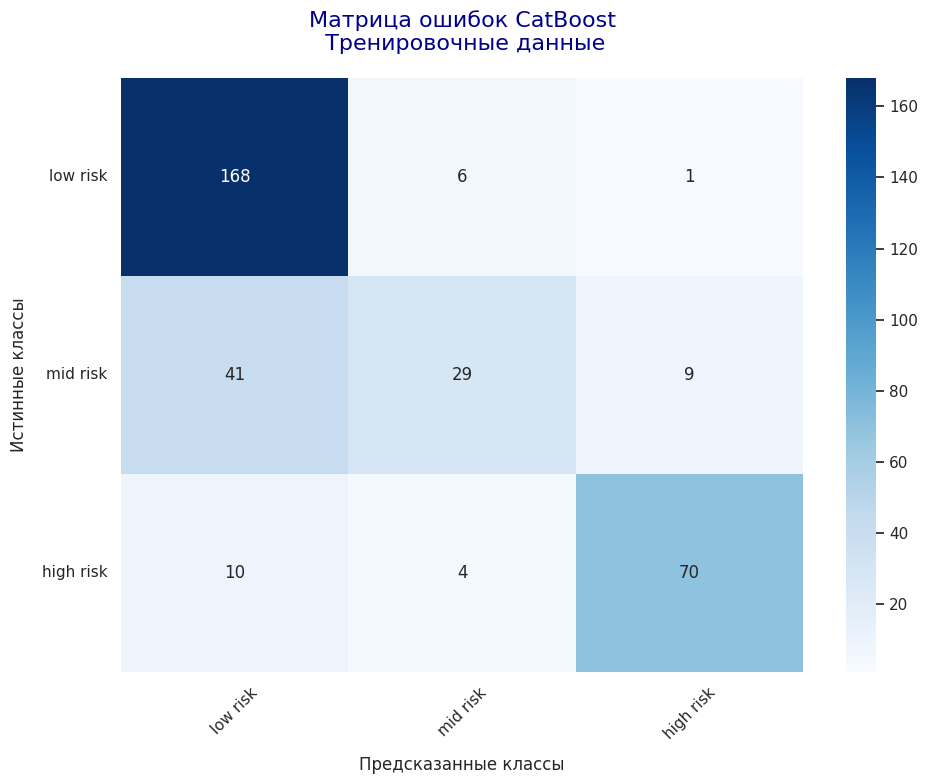

In [ ]:
# применяем функцию для построения матрицы ошибок на тренировочных данных
cm = plot_catboost_confusion_matrix(y_train, cb_results['model'].predict(X_train),
                                    INVERSE_RISK_MAPPING, 'Тренировочные данные')

Модель хорошо работает с высоким и низким уровнем риска - она предсказывает их уверенно и полно.

Однако уже видна проблема: даже на уже известных ей данных модель склонна занижать уровень степень риска для среднего класса.

Теперь взгляну на матрицу для тестовых данных.

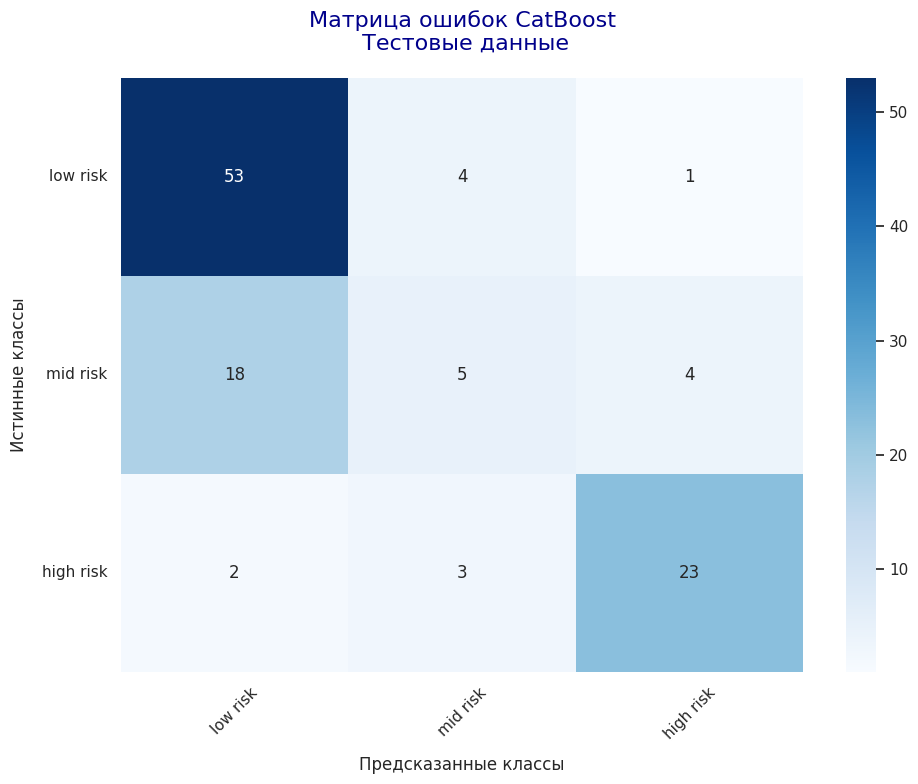

In [ ]:
# применяем функцию для построения матрицы ошибок на тестовых данных
cm = plot_catboost_confusion_matrix(y_test, y_test_pred, INVERSE_RISK_MAPPING, 'Тестовые данные')

При анализе матрицы ошибок можно увидеть, что модель:

- хорошо справляется с идентификацией пациенток с реально низким и высоким риском. Это очень важно, так как позволяет направить усилия и ресурсы на группу выского риска и успокоить и вести стандартное наблюдение за группой низкого риска.
- критически слабо работает со средним риском, что является серьезной проблемой модели в медицинском контексте. Ведь те две трети женщин, которым она ошибочно занизила риск, не получат должного внимания и помощи, в результате чего возможны еще большие осложнения.
- при этом имеет опасные ошибки для женщин высокой степени риска: нескольким он занизил риск до среднего, а еще нескольких отметил как низкий риск.

То есть проблема сос редним классом (склонность к занижению степени риска) сохраняется.

Выведу дополнительно метрики для лучшей интерпретации качества модели.

In [ ]:
# создаем функцию для подсчета метрик
# и анализа ошибок (в т.ч. по классам)
def analyze_catboost_errors(y_true, y_pred, inverse_mapping):
    """
    Детальный анализ ошибок с учетом порядковой природы данных
    """
    print("═" * 60)
    print(color.BLUE + color.BOLD + f" ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК CatBoost"+ color.END)
    print("═" * 60)

    # основные метрики
    qwk_test = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    macro_f1_test = f1_score(y_true, y_pred, average='macro')
    balanced_acc_test = balanced_accuracy_score(y_true, y_pred)  # главная из двух accuracy
    accuracy_test = accuracy_score(y_true, y_pred)  # оставляем для справки

    print(color.BLUE + color.BOLD + f"\nМетрики на тестовых данных:"+ color.END)
    print(f"   QWK: {qwk_test:.4f}")
    print(f"   Macro F1: {macro_f1_test:.4f}")
    print(f"   Balanced Accuracy: {balanced_acc_test:.4f}")  # главная из двух accuracy
    print(f"   Standard Accuracy: {accuracy_test:.4f}")  # оставляем для справки

    # анализ серьезности ошибок
    errors = y_true != y_pred
    error_severity = np.abs(y_true[errors] - y_pred[errors])

    print(color.BLUE + color.BOLD + f"\nАнализ ошибок:" + color.END)
    print(f"   Всего ошибок: {errors.sum()} ({errors.mean():.1%})")
    print(f"   Средняя серьезность ошибки: {error_severity.mean():.2f} категории")

    # типы ошибок
    error_types = {
        'Точное предсказание': (y_true == y_pred).sum(),
        'Ошибка на 1 категорию': (np.abs(y_true - y_pred) == 1).sum(),
        'Ошибка на 2 категории': (np.abs(y_true - y_pred) == 2).sum()
    }

    print(color.BLUE + color.BOLD + f"\nТипы ошибок:" + color.END)
    for error_type, count in error_types.items():
        proportion = count / len(y_true)
        print(f"   {error_type}: {count} ({proportion:.1%})")

    # анализ по классам с Balanced подходом
    print(color.BLUE + color.BOLD + f"\nДетальный анализ по классам:" + color.END)
    for class_id in np.unique(y_true):
        class_name = inverse_mapping[class_id]
        class_mask = y_true == class_id
        class_accuracy = (y_pred[class_mask] == class_id).mean()
        class_size = class_mask.sum()
        class_proportion = class_size / len(y_true)

        print(f"   {class_name}:")
        print(f"      • Accuracy: {class_accuracy:.1%}")
        print(f"      • Размер класса: {class_size} ({class_proportion:.1%})")
        print(f"      • Ошибки: {class_size - (y_pred[class_mask] == class_id).sum()}")

In [ ]:
# используем функцию
# .flatten() нужен, так как CatBoost дает предксазание не вектором,
# а матрицей (в данном случае Размер y_test_pred был (113, 1))
analyze_catboost_errors(y_test, y_test_pred.flatten(), INVERSE_RISK_MAPPING)

════════════════════════════════════════════════════════════
 ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК CatBoost
════════════════════════════════════════════════════════════

Метрики на тестовых данных:
   QWK: 0.7486
   Macro F1: 0.6290
   Balanced Accuracy: 0.6401
   Standard Accuracy: 0.7168

Анализ ошибок:
   Всего ошибок: 32 (28.3%)
   Средняя серьезность ошибки: 1.09 категории

Типы ошибок:
   Точное предсказание: 81 (71.7%)
   Ошибка на 1 категорию: 29 (25.7%)
   Ошибка на 2 категории: 3 (2.7%)

Детальный анализ по классам:
   low risk:
      • Accuracy: 91.4%
      • Размер класса: 58 (51.3%)
      • Ошибки: 5
   mid risk:
      • Accuracy: 18.5%
      • Размер класса: 27 (23.9%)
      • Ошибки: 22
   high risk:
      • Accuracy: 82.1%
      • Размер класса: 28 (24.8%)
      • Ошибки: 5


Главная метрика QWK (Quadratic Weighted Kappa) показывает хорошее согласие с экспертом. При этом она лучше метрики модели на кросс-валидации, но хуже (что логично) таковой на тренировочной. Возможно, на нее влияют правильно предсказаные истинные высокие и низкие степени риска.

Значение Macro F1 указывает на указывает на неустойчивое и ненадежное качество модели (а показатель данной метрики < 0.7 в принципе считается недостаточным для медицинских применений) - это мы могли наблюдать на примере среднего класса.

Balanced Accuracy показывает умеренное качество, но с наличием проблем.

Оставленная для справки Standard Accuracy обманчиво высокая из-за дисбаланса классов (демонстрируя наглядно разницу между двумя типами Accuracy).

То есть модель имеет потенциал, но пока неприменима клинически ввиду плохой работы с классом среднего риска (и создания чувства ложной безопасности у данной группы).

Может применяться лишь ограниченно как вспомогательный инструмент скрининга с обязательной врачебной верификацией и вниманием к пограничным состоянием (ввиду чего в принципе может теряться смысл ее использования как инструмента).

К проблемам качества предсказаний модели могли привести как проблемы самой модели, требующие доработки (например, можно перевесить классы, усилив внимание на среднем классе), так и проблемы данных, на которых она обучалась: малое количество данных, малое количество признаков (среди которых могут отсутствовать те, которые также влияют на классы, в результате чего пациентки с одинаковыми данными имели разные степени риска), недостаточная представленность класса со средним риском.



### **Выводы**

Я построила матрицы ошибок и вывела различные метрики (основные и дополнительные) модели и проанализировала их.

В результате анализа можно сделать выводы, что модель:
- хорошо справляется с идентификацией женщин с реально низким и высоким риском.
- критически слабо работает со средним риском, что является серьезной проблемой модели в медицинском контексте.
- при этом имеет опасные ошибки для женщин высокой степени риска: нескольким он занизил риск до среднего, а еще нескольких отметил как низкий риск.
- имеет хороший потенциал, однако также имеет проблемы и неустойчивое ненадежное качество.
- вероятно, модель может путать средний класс с двумя остальными, так как средний класс занимает промежуточное ввиду между двумя остальными классами, и модели недостоточно данных для того, чтобы четко отделять его от остальных.

То есть модель клинически не применима и требует доработки/обучения на новых данных.

К имеющемуся уровню качества могли привести как проблемы самой модели, так и проблемы в данных, на которых она обучалась.



## **Выводы**

В рамках проекта я загрузила и изучила данные, и процессе обнаружила в них следующие проблемы:
- малое количество данных;
- большое количество дубликатов;
- малое количество признаков, что не позволяет разделять отдельных пациенток;
- отсутствие признаков, дополнительно влияющих на отнесение к определенному классу (в результате чего строки с одними и теми же показателями получали разный целевой класс).

После предварительной подготовки данных я обучила  7 моделей (одну Dummy, 4 "обычных" и 3 ансамблевых). Лучшей моделью по результатам обучения стала CatBoost, с метрикой QWK на кросс-валидации 0.7037.

Дальнейшее исследование лучшей модели показало, что модель:
- в целом хорошо справляется с идентификацией пациенток с реально низким и высоким риском, однако имеют место быть опасные случаи занижения на 1 или 2 уровня риска у высокой степени;
- критически слабо работает со средним риском (склонна занижать его).

В результате итоговая лучшая модель не пригодна к самостоятельному клиническому применению.

Пути улучшения качества модели:
- доработка самой модели (например, обучения с другими параметрами);
- устранение проблем с данными (например, увеличив их количество и качество, а также - представленность среднего класса).

Так как данные являются основой для работы со всеми моделями, то устранения проблем с ними (в случае возможности), по моему мнению, является главным направлением для дальнейшей работы.

# **Дополнительный (Экспериментальный) раздел**

В рамках данного раздела я попробую провести некоторые эксперименты, чтобы улучшить качество предсказаний лучшей модели.

Так как полученные данные изначально были проблемные, вероятность увеличить качество модели невелика. Но на сами данные повлиять нельзя (взять новые неоткуда), а вот несколько экспериментов с моделью провести - можно.

## **Эксперимент 1**

Для начала в качестве эксперимента я попробую поменять веса лучшей модели.

Вероятно, проводить сравнение изменений на тесте не совсем корректно. Но так как это экспериментальный раздел, то мне хотелось бы все же увидеть изменения в "конечном продукте" (ведь именно его мы стремимся улучшить) в зависимости от весов, то подобный вариант, по моему мнению, является более наглядным вариантом демонстрации, что проблема, с большой долей вероятности, не сколько в модели, а в данных.

In [ ]:
# берем лучшие параметры из предыдущего обучения
best_params = cb_results['best_params'].copy()

# убираем префикс 'catboost__' из ключей параметров
catboost_params = {}
for key, value in best_params.items():
    if key.startswith('catboost__'):
        new_key = key.replace('catboost__', '')
        catboost_params[new_key] = value
    else:
        catboost_params[key] = value

# тестируем разные варианты весов
weight_variants = {
    'Без весов': {**catboost_params},
    'Auto Balanced': {**catboost_params, 'auto_class_weights': 'Balanced'},
    'Auto SqrtBalanced': {**catboost_params, 'auto_class_weights': 'SqrtBalanced'},
    'Ручные веса [1, 3, 2]': {**catboost_params, 'class_weights': [1, 3, 2]}
}

results = {}
for name, params in weight_variants.items():
    print(f"\n{'═'*60}")
    print(color.GREEN + color.BOLD + f"ТЕСТИРУЕМ: {name}" + color.END)
    print(f"{'═'*60}")

    model = CatBoostClassifier(**params, random_state=RANDOM_STATE, verbose=100)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test).flatten()
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'qwk': cohen_kappa_score(y_test, y_pred, weights='quadratic')
    }

    analyze_catboost_errors(y_test, y_pred, INVERSE_RISK_MAPPING)

# итоговое сравнение
print("\n" + "═"*60)
print(color.GREEN + color.BOLD + f"ИТОГОВОЕ СРАВНЕНИЕ ВАРИАНТОВ ВЕСОВ:" + color.END)
print("═"*60)
for name, result in results.items():
    print(f"{name}: QWK = {result['qwk']:.4f}")

# выбираем лучший вариант
best_variant = max(results.items(), key=lambda x: x[1]['qwk'])
print(color.GREEN + color.BOLD + f"\nЛУЧШИЙ ВАРИАНТ: {best_variant[0]} (QWK = {best_variant[1]['qwk']:.4f})" + color.END)


════════════════════════════════════════════════════════════
ТЕСТИРУЕМ: Без весов
════════════════════════════════════════════════════════════
0:	learn: 1.0760771	total: 757us	remaining: 75ms
99:	learn: 0.5754444	total: 58.7ms	remaining: 0us
════════════════════════════════════════════════════════════
 ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК CatBoost
════════════════════════════════════════════════════════════

Метрики на тестовых данных:
   QWK: 0.7486
   Macro F1: 0.6290
   Balanced Accuracy: 0.6401
   Standard Accuracy: 0.7168

Анализ ошибок:
   Всего ошибок: 32 (28.3%)
   Средняя серьезность ошибки: 1.09 категории

Типы ошибок:
   Точное предсказание: 81 (71.7%)
   Ошибка на 1 категорию: 29 (25.7%)
   Ошибка на 2 категории: 3 (2.7%)

Детальный анализ по классам:
   low risk:
      • Accuracy: 91.4%
      • Размер класса: 58 (51.3%)
      • Ошибки: 5
   mid risk:
      • Accuracy: 18.5%
      • Размер класса: 27 (23.9%)
      • Ошибки: 22
   high risk:
      • Accuracy: 82.1%
      • Размер класса

Лучшей моделью по-прежнему осталась та, которую я нашла ранее.

## **Эксперимент 2**

В рамках данного эксперимента я обучу лучшую модель заново, используя дополнительные настройки при инициализации. Изменение же гиперпараметров я трогать в рамках данного эксперимента (для его чистоты) не буду.

In [ ]:
# создаем функцию по образцу для CatBoost
# учтем, что модели, основанные на деревьях, не требуют дополнительного масштабирования
# CatBoost также не требует кодирования, но у нас оно в признаках не используется
# добавляем дополнительные настройки при инициализации
def CatBoost_Classifier_new(X_train, y_train):
    """
    функция с CatBoost для порядковой классификации:
    -- с заданной ранее (до функции) через make_scorer одной основной метрикой (QWD) для кросс-валидации,
    -- и дополнительным вычислением двух метрик (QWD и Macro F1-score), вычисляемой для лучшей модели
    - с обработкой пропусков (CatBoost сам умеет работать с пропусками);
    - с кросс-валидацией;
    - с перебором параметров с помощью GridSearchCV;
    - с сохранением лучшей модели, ее параметров и метрик в свой словарь;
    - с отдельным таймером обучения лучшей модели.
    - с дополнительно прописаными:
    -- лосс-функцией
    -- весами
    """

    # CatBoost сам умеет обрабатывать пропуски, поэтому можно без imputer
    pipe_catboost = Pipeline([
        ('catboost', CatBoostClassifier(
            random_state=RANDOM_STATE,  # фиксация рандома
            # задаем функцию потерь:
            loss_function='MultiClass',
            auto_class_weights='Balanced', # важно для несбалансированных данных
            verbose=0,  # отключаем вывод логов
            thread_count=-1  # используем все ядра
        ))
    ])

    # определение сетки гиперпараметров для CatBoost
    param_grid = {
      'catboost__iterations': [100, 200],              # количество деревьев (аналог n_estimators)
      'catboost__learning_rate': [0.05, 0.1],          # скорость обучения (чем меньше, тем точнее, но медленнее)
      'catboost__depth': [6, 8],                       # глубина деревьев (сложность модели)
      'catboost__l2_leaf_reg': [3, 5]                 # коэффициент L2 регуляризации (защита от переобучения)
    }

    # создаем кросс-валидацию с фиксированным random_state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # создание GridSearchCV с QWK как основной метрикой
    grid_search = GridSearchCV(
        estimator=pipe_catboost,  # модель-пайплайн
        param_grid=param_grid,  # параметры
        scoring=QWK_SCORER,  # метрика
        refit=False,  # НЕ переобучаем модель сразу
        n_jobs=1,  # CatBoost не любит n_jobs=-1, лучше 1
        cv=cv,  # фолды для кросс-валидации
        verbose=1  # не отключаем вывод
    )

    # обучение GridSearchCV (только поиск по параметрам)
    grid_search.fit(X_train, y_train)

    # получение лучших параметров
    best_params = grid_search.best_params_
    best_qwk_score = grid_search.best_score_

    # теперь обучаем лучшую модель отдельно и замеряем время
    start_time = time.time()
    best_model = pipe_catboost.set_params(**best_params).fit(X_train, y_train)
    best_model_time = time.time() - start_time

    # вычисляем ОБЕ метрики на тренировочных данных в одинаковых условиях
    y_pred = best_model.predict(X_train)
    qwk_train = cohen_kappa_score(y_train, y_pred, weights='quadratic')
    macro_f1_train = f1_score(y_train, y_pred, average='macro')

    print(color.BLUE + color.BOLD + f"\nЛучшая QWK при CV: " + color.END + f"{best_qwk_score:.4f}")
    print(color.BLUE + color.BOLD + f"QWK на тренировочных данных: " + color.END + f"{qwk_train:.4f}")
    print(color.BLUE + color.BOLD + f"Macro F1 на тренировочных данных: " + color.END + f"{macro_f1_train:.4f}")
    print(color.BLUE + color.BOLD + f"Лучшие параметры: " + color.END + f"{best_params}")
    print(color.BLUE + color.BOLD + f"Время обучения лучшей модели: " + color.END + f"{best_model_time:.4f} секунд")

    # анализ предсказаний
    print(color.BLUE + color.BOLD + f"\nРаспределение предсказаний:" + color.END)
    for class_id in np.unique(y_train):
        count = np.sum(y_pred == class_id)
        proportion = count / len(y_pred)
        print(f"Класс {class_id}: {count} предсказаний ({proportion:.1%})")

    return {
        'model': best_model,  # лучшая модель
        'best_qwk_cv': best_qwk_score,  # лучшая QWK при CV
        'qwk_train': qwk_train,  # QWK на тренировочных данных
        'macro_f1_train': macro_f1_train,  # Macro F1 на тренировочных данных
        'best_params': best_params,  # лучшие параметры
        'best_model_time': best_model_time,  # время обучения только лучшей модели
    }

In [ ]:
# тренируем модель
# вызов функции и сохранение результатов
%time cb_new_results = CatBoost_Classifier_new(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Лучшая QWK при CV: 0.7102
QWK на тренировочных данных: 0.8026
Macro F1 на тренировочных данных: 0.7777
Лучшие параметры: {'catboost__depth': 6, 'catboost__iterations': 100, 'catboost__l2_leaf_reg': 3, 'catboost__learning_rate': 0.05}
Время обучения лучшей модели: 0.0882 секунд

Распределение предсказаний:
Класс 0: 183 предсказаний (54.1%)
Класс 1: 72 предсказаний (21.3%)
Класс 2: 83 предсказаний (24.6%)
CPU times: user 22.6 s, sys: 3.65 s, total: 26.3 s
Wall time: 17.5 s


Главная метрика улучшилась, метрики на тренировочных данных также стали выше (но и склонность к переобучению - тоже).

Также можно увидеть, что модель стала чаще предсказывать средний класс.

Исследуем новую модель аналогично ранее лучшей.

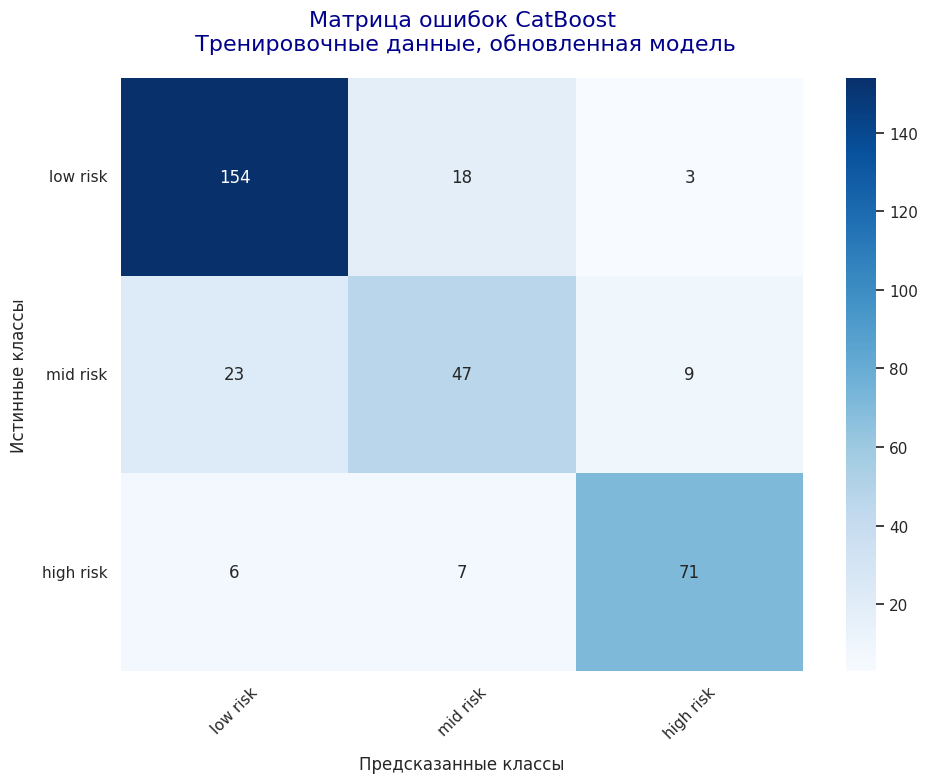

In [ ]:
# применяем функцию для построения матрицы ошибок на тренировочных данных
cm_new = plot_catboost_confusion_matrix(y_train, cb_new_results['model'].predict(X_train),
                                    INVERSE_RISK_MAPPING, 'Тренировочные данные, обновленная модель')

Модель несколько потеряла в уверенности касательно низкого и высокого риска, но стала точнее предсказывать средний класс.

In [ ]:
# делаем предсказания лучшей обновленной моделью CatBoost на тестовых данных
y_test_pred_new = cb_new_results['model'].predict(X_test)

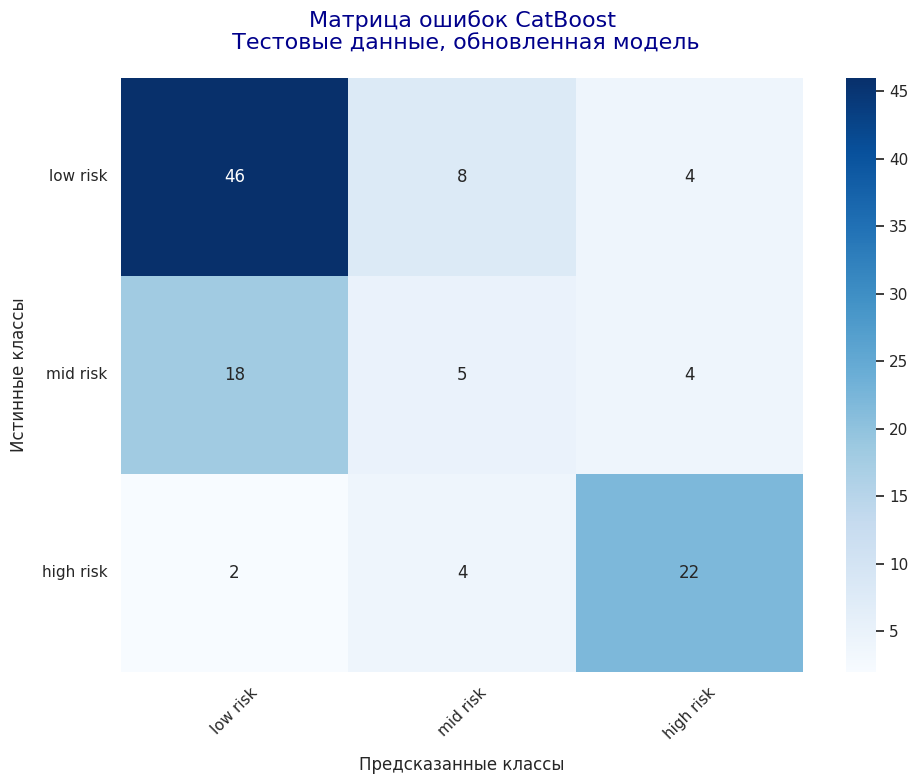

In [ ]:
# применяем функцию для построения матрицы ошибок на тестовых данных
cm = plot_catboost_confusion_matrix(y_test, y_test_pred_new,
                                    INVERSE_RISK_MAPPING, 'Тестовые данные, обновленная модель')

In [ ]:
# используем функцию
# .flatten() нужен, так как CatBoost дает предксазание не вектором,
# а матрицей (в данном случае Размер y_test_pred был (113, 1))
analyze_catboost_errors(y_test, y_test_pred_new.flatten(), INVERSE_RISK_MAPPING)

════════════════════════════════════════════════════════════
 ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК CatBoost
════════════════════════════════════════════════════════════

Метрики на тестовых данных:
   QWK: 0.6439
   Macro F1: 0.5759
   Balanced Accuracy: 0.5880
   Standard Accuracy: 0.6460

Анализ ошибок:
   Всего ошибок: 40 (35.4%)
   Средняя серьезность ошибки: 1.15 категории

Типы ошибок:
   Точное предсказание: 73 (64.6%)
   Ошибка на 1 категорию: 34 (30.1%)
   Ошибка на 2 категории: 6 (5.3%)

Детальный анализ по классам:
   low risk:
      • Accuracy: 79.3%
      • Размер класса: 58 (51.3%)
      • Ошибки: 12
   mid risk:
      • Accuracy: 18.5%
      • Размер класса: 27 (23.9%)
      • Ошибки: 22
   high risk:
      • Accuracy: 78.6%
      • Размер класса: 28 (24.8%)
      • Ошибки: 6


На матрице наблюдается потеря в точности предсказаний для высокого и низкого риска при сохранении того же проблемного уровня (склонности к занижению) у среднего.

Метрики на тесте упали, то есть модель стала еще хуже (при этом средний класс она предсказывает точно так же, как и предыдущая).

Так как первые два эксперимента не приводят к повышению качества модели, то эксперимент с изменением гиперпараметров проводить не буду. Ведь, по моему мнению, основная проблема кроется в невысоком качестве данных.

### **Выводы**

- Попытки повысить главную метрику лучшей из моделей не увенчалась успехом.
- Для дальнейших попыток необходимы новые, более качественные, данные.